!pip3 install jupyterthemes --user

In [1]:
#!pip3 install jupyterthemes --user
#import jupyterthemes as jt
#from jupyterthemes.stylefx import set_nb_theme

#set_nb_theme('chesterish')

In [2]:
#load libraries 
import time,os
from matplotlib.offsetbox import AnchoredText
import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines, numpy as np, math, pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#import cudf
#import ROOT
#from ROOT import TFile

#import root_pandas

#from toggle_cell import hide_cell 
#import uproot3
%matplotlib inline

#presets for plot style
from scipy.constants import golden
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (7, 7/golden),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

viridis = cm.get_cmap('viridis', 12)
inferno = cm.get_cmap('inferno', 12)
autumn = cm.get_cmap('autumn', 12)

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.experimental.set_memory_growth(physical_devices[1], True)
rc = plt.rc
rc('text', usetex=False)
import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=15)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

import root_pandas,glob

import gc

import uproot
def read_n(pattern, n):
    if not '*' in pattern:
        a = root_pandas.read_root(pattern,chunksize=int(n))
    else:
        a = root_pandas.read_root(glob.glob(pattern),chunksize=int(n))
    for b in a:
        del a
        print(n)
        return b

from scipy.optimize import curve_fit

image_dir='images'

#import misc_util#correlation_plots

import R2h_module
#import imp
#imp.reload(R2h_module)

import mplhep as hep
hep.style.use("CMS")

In [3]:
#sets =  "D_C C D_Fe Fe Pb D_Pb".split()
#sets += "MC_D2 MC_C MC_Fe MC_Pb".split()
#sets += "no_ecuts_D_C no_ecuts_C no_ecuts_D_Fe no_ecuts_Fe no_ecuts_Pb no_ecuts_D_Pb".split()
#sets += "xQ2_D_C xQ2_C xQ2_D_Fe xQ2_Fe xQ2_Pb xQ2_D_Pb".split()

#dfs_mixed = {a : root_pandas.read_root("../../eg2/python/mixed_%s.root"%a)  for a in sets}

#mixtag='xQ2_'
#dfs_mixed = {a : root_pandas.read_root(f"/data/sebouh/eg2/python/mixed_{mixtag}{a}.root")  for a in "D_C C D_Fe Fe Pb D_Pb".split()}


In [4]:
def getdatainChunks(filename,treename):
    import pickle
    with open(filename, 'rb') as f:
        return pickle.load(f)[treename]

In [5]:
%%time
dfs_pair = {}
dfs_trigger = {}
#path_data="/home/sebouh/di-hadron"
#path_data="/home/seba/di-hadron/P27"
path_data="/media/eic_ucr/sebouh/di-hadron/P27"
path_data="/media/miguel/Elements/backup_07-27-23/nvme0n1p2/home/seba/di-hadron/P27/"
path_data="P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    dfs_pair[target]=getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", target)
    dfs_pair['D_%s'%target]= getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    dfs_trigger['%s'%target] = getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", 
                                                      '%s_trigger'%target)
    dfs_trigger['D_%s'%target] = getdatainChunks(f"data_pion_proton_pairs_{target}.pkl", 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 25.7 ms, sys: 896 ms, total: 921 ms
Wall time: 922 ms


In [6]:
# #get GiBUU
# import uproot

# def getdatainChunks(filename,treename):
#     dataframe =pd.DataFrame()
#     file = uproot.open(filename) 
#     tree=file[treename]
#     df=tree.arrays(filter_name='*',library='pd')
#     return df

# pathGIBUU="./"
# for target in ['D','C','Fe','Pb']:
#     for suffix in "", "_tweak", "_tweak2","_tweak_harut":
#         #GiBUU
#         print (target+suffix)
#         print (' trigger')
#         dfs_trigger['GiBUU_%s'%target+suffix]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target+suffix), 
#                                                                '%s_trigger'%target)
#         print (' pairs')
#         dfs_pair['GiBUU_%s'%target+suffix]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target+suffix),target)
# print (dfs_trigger.keys())

In [7]:
for dct in dfs_pair, dfs_trigger:
    print(dct.keys())
    dct['D'] = pd.concat([dct['D_'+a] for a in 'C Fe Pb'.split()])

dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])
dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])


In [8]:
%%time
import R2h_module as r2h

for key in dfs_pair.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    dfs_pair[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_pair[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    dfs_pair[key] = r2h.applyCuts(dfs_pair[key],isMC=isMC, nomCuts=True)
    dfs_pair[key] = r2h.applyCutsPair(dfs_pair[key],isMC=isMC, nomCuts=True, h2Proton=True)


key:  C
Entries before cut  46028
Q2>1.0 and Q2<4.0 46028  (100.00  %)
0.2<h1_p<5.0  46028  (100.00  %)
inelasticity < 0.85 44727  (97.17  %)
h1_pid = pions (trigger) 44727  (100.00  %)
2.2 < nu <4.2 44044  (98.47  %)
10< h1_th 44044  (100.00  %)
Theta/P fiducial region selected for trigger hadron 44044  (100.00  %)
Nom cuts for the trigger applied 44044  (100.00  %)
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44044  (100.00  %)
2.2 < nu < 4.2 44044  (100.00  %)
secondary hadrons are protons 44044  (100.00  %)
leading hadrons are pions 44044  (100.00  %)
0.2<h2_p<5.0 44044  (100.00  %)
0.2<h1_p<5.0 44044  (100.00  %)
10<h2_th 44044  (100.00  %)
Theta/P fiducial region selected for secondary hadron 44044  (100.00  %)
10< h1_th 44044  (100.00  %)
Theta/P fiducial region selected for trigger hadron 44044  (100.00  %)
Nom cuts for the pair applied (pi p) 44044  (100.00  %)

key:  D_C
Entries before cut  37893
Q2>1.0 and Q2<4.0 37893  (100.00  %)
0.2<h1_p<5.0  37893  (1

In [9]:
for key in dfs_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    dfs_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    dfs_trigger[key] = r2h.applyCuts(dfs_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    

C False
Entries before cut  218901
Q2>1.0 and Q2<4.0 218901  (100.00  %)
0.2<h1_p<5.0  218901  (100.00  %)
inelasticity < 0.85 213870  (97.70  %)
h1_pid = pions (trigger) 213870  (100.00  %)
2.2 < nu <4.2 211085  (98.70  %)
10< h1_th 211085  (100.00  %)
Theta/P fiducial region selected for trigger hadron 211085  (100.00  %)
Nom cuts for the trigger applied 211085  (100.00  %)
 
D_C False
Entries before cut  304772
Q2>1.0 and Q2<4.0 304772  (100.00  %)
0.2<h1_p<5.0  304772  (100.00  %)
inelasticity < 0.85 298466  (97.93  %)
h1_pid = pions (trigger) 298466  (100.00  %)
2.2 < nu <4.2 294870  (98.80  %)
10< h1_th 294870  (100.00  %)
Theta/P fiducial region selected for trigger hadron 294870  (100.00  %)
Nom cuts for the trigger applied 294870  (100.00  %)
 
Fe False
Entries before cut  263034
Q2>1.0 and Q2<4.0 263034  (100.00  %)
0.2<h1_p<5.0  263034  (100.00  %)
inelasticity < 0.85 257258  (97.80  %)
h1_pid = pions (trigger) 257258  (100.00  %)
2.2 < nu <4.2 253998  (98.73  %)
10< h1_th 2

In [10]:
set(dfs_pair['D'].h2_pid)


{2212}

In [11]:
# import R2h_module
# import imp
# imp.reload(R2h_module)
# for key in list(dfs_mixed.keys()):
#     isMC=False
#     if 'GiBUU' in key:
#         isMC=True
#     dfs_mixed[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
#     dfs_mixed[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    
#     print(f"\n\n{key}")
#     if  'dphi' not in dfs_mixed[key].columns:
#         dfs_mixed[key].eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
#         dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm-{2*np.pi}*(diff_phi_cm>{np.pi})', inplace=True)
#         dfs_mixed[key].eval(f'diff_phi_cm = diff_phi_cm+{2*np.pi}*(diff_phi_cm<{-np.pi})', inplace=True)
#         dfs_mixed[key].eval(f'dphi = abs(diff_phi_cm)', inplace=True)
#     dfs_mixed[key].eval('h1_e=nu*h1_z',inplace=True)
#     dfs_mixed[key].eval('h2_e=nu*h2_z',inplace=True)
#     dfs_mixed[key].eval(f'drap=0.5*log((h1_e+sqrt(h1_p**2-h1_cm_pt**2))/(h1_e-sqrt(h1_p**2-h1_cm_pt**2)))-0.5*log((h2_e+sqrt(h2_p**2-h2_cm_pt**2))/(h2_e-sqrt(h2_p**2-h2_cm_pt**2)))',inplace=True)

#     mixed_trigger_cuts = dfs_mixed[key]#R2h_module.applyCuts(dfs_mixed[key])    
#     dfs_mixed[key] = R2h_module.applyCutsPair(mixed_trigger_cuts,isMC=isMC,
#                                                              nomCuts=True,h2Proton=False, minPt=np.sqrt(0.005))
    
    

In [12]:
#dfs_mc= {f"{a}_2pi":root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{a}.root",a) for a in "C Fe Pb".split()}
#dfs_mc["D_2pi"] = root_pandas.read_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_C.root","D_C")

In [13]:
# additional cuts that were not applied to the GiBUU set in PRL,
# but we should see what happens if we include them.  
pThetaCuts_trig=' ((h1_pid==211 and h1_th>10) or (h1_pid==2212))'

#pThetaCuts_trig+=" and h1_th>20 and h1_p<2.7"

pThetaCuts_pair=pThetaCuts_trig 
pThetaCuts_pair += " and " + pThetaCuts_trig.replace("h1_", "h2_")



In [14]:
#print(<h2_T4)
# https://www.jlab.org/Hall-B/shifts/admin/paper_reviews/2012/TransparencyAnalysisNoteApproved-7233807-2012-10-03-v5.pdf
def poly(a, coeffs):
    ret=0
    for i in range(len(coeffs)):
        ret=ret+coeffs[i]*a**i
    return ret
for df in dfs_pair.values():
    p=df.h2_p#eval("sqrt(h2_E**2-0.09383**2)")
    T4=df.h2_T4
    coeffs_high_range1=120.251,-1168.19,5237.42,-13638.1,22325.3,-23649.6,16177.8,-6894.16,1663.4,-173.474
    coeffs_low_range1=-26.8257,153.155,-408.979,673.476,-790.433,708.255,-474.843,217.295,-58.6269,6.90981
    coeffs_high_range2=1.59223,-1.49056,0.676338,-0.104644
    coeffs_low_range2=-1.1009,0.719988,-0.280016,0.0319352
    df['pass_proton_TOF_cut']=((p>0.2)&(p<0.8)&(T4<poly(p,coeffs_high_range1))&(T4>poly(p,coeffs_low_range1)))|\
                  ((p>=0.8)&(p<2.8)&(T4<poly(p,coeffs_high_range2))&(T4>poly(p,coeffs_low_range2))) 
    print(len(df.query('pass_proton_TOF_cut'))/len(df))


0.9646716919444193
0.9569410859529567
0.968310226206609
0.9556853624677736
0.9688627223350885
0.9560483941772463
0.9561313907854416


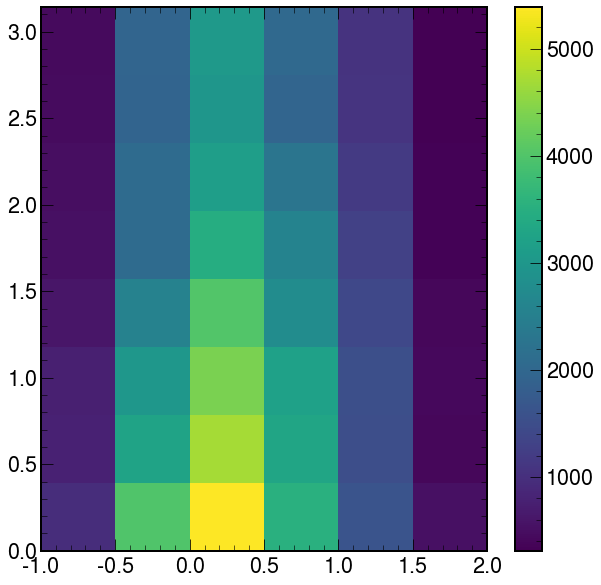

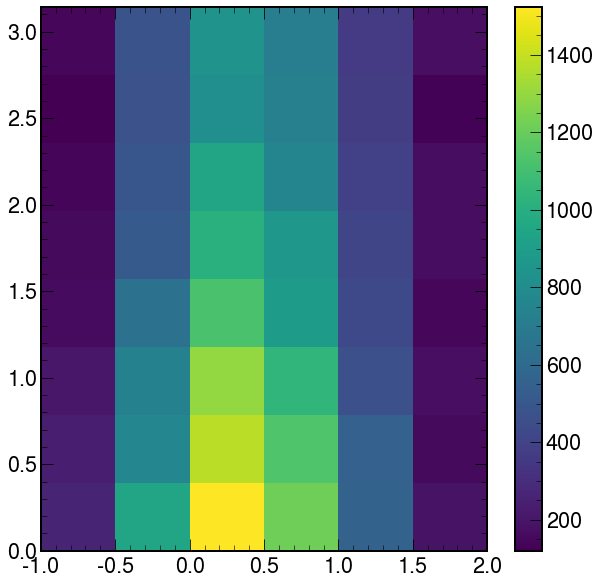

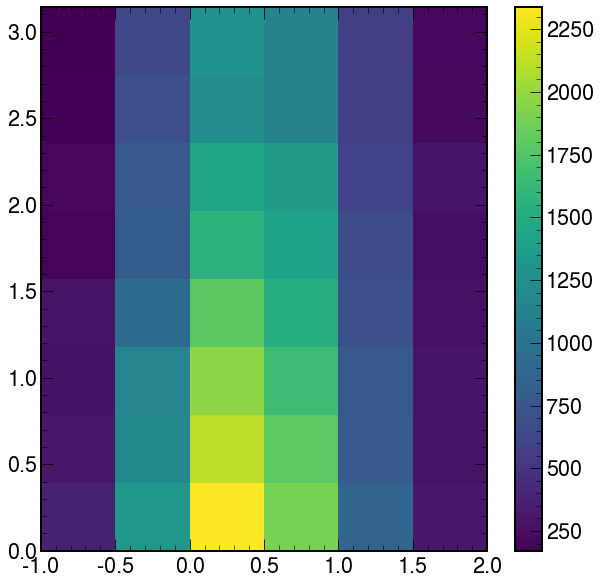

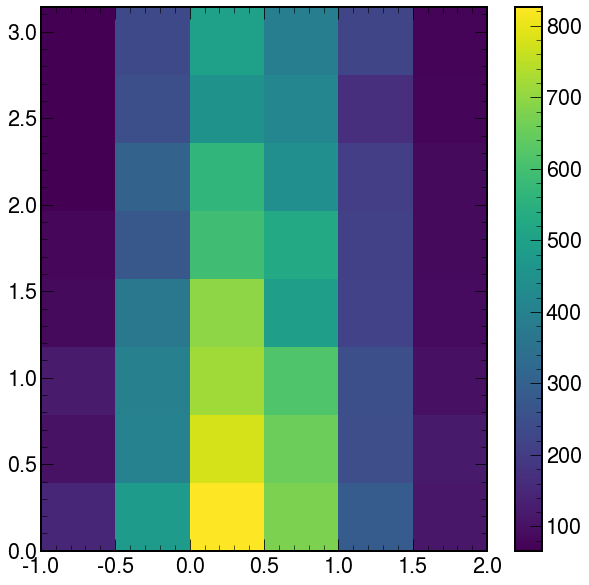

In [43]:

pT1min=0.07
pT2min=0.07
pMin=0.2
addCuts=None
 
slice_range=slicebins[k:k+2]

data_D=None
stat_D=None
Alist = enumerate("D C Fe Pb".split())

for i, A in Alist:

    

    q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
         f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
    

    bins = np.linspace(0,np.pi,nbins_data+1)
    phi1=np.array(dfs_pair[A].query(q)['h1_cm_ph'])
    phi2=np.array(dfs_pair[A].query(q)['h2_cm_ph'])
    rap1=np.array(dfs_pair[A].query(q).eval('h1_rap-ycm'))
    rap2=np.array(dfs_pair[A].query(q)['h2_rap'])
    phi2=np.roll(phi2,3)
    rap2=np.roll(rap2,3)
    
    N2, x,y,hist = plt.hist2d(rap1-rap2,np.abs(phi1-phi2), bins=(np.linspace(-1,2, 7), np.linspace(0,np.pi,9)))
    plt.colorbar()
    plt.show()
        
        

AttributeError: module 'numpy' has no attribute 'rotate'

In [15]:
def get_values(slicevar='drap', slicevartex='\Delta Y', slicebins=(-1,0,1,2,3), saveFig=False,
              pThetaCutsGiBUU=True, pMin=.4, pT1min=.25, pT2min=.25,
               suptitle=None,nbins_data=8, nbins_GiBUU=16, GiBUU_suffix="",
              addCuts=None, addCutsTrig=None, sliceNh=False):
    #unbinned.
    if slicevar is None:
        slicebins=[0,1]
    
    data=[]
    GiBUU=[]
    sliceinfo={}
    
    #guess for the systematic errors from sources not inves
    systPct=0
    pid=211
    
    integral_data_D = 0
    for k in range(len(slicebins)-1):
        data.append({})
        GiBUU.append({})
        slice_range=slicebins[k:k+2]

        data_D=None
        stat_D=None
        Alist = enumerate("D C Fe Pb".split())
        for i, A in Alist:

            

            q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
            
            if slicevar != None:
                q+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
            
            if addCuts is not None:
                q+= f" and {addCuts}"

            which_set=A

            bins = np.linspace(0,np.pi,nbins_data+1)

            N2, x = np.histogram(dfs_pair[A].query(q)['dphi'], bins=bins)
            
            
            qtrig = pThetaCuts_trig+f" and h1_pid=={pid} and  h1_cm_pt > {pT1min}"
            
            if sliceNh:
                qtrig+= f" and {slicevar}>={slice_range[0]} and {slicevar}<{slice_range[1]}"
            
            if addCutsTrig is not None:
                qtrig += f" and {addCutsTrig}"
            
            N1 = len(dfs_trigger[A].query(qtrig))

            x = (x[1:]+x[:-1])/2
            dx = x[1]-x[0]

            S = N2/dx/N1/2
            dSstat = np.sqrt(N2*(N1-N2)/N1**3)/dx/2

            C=S
            dCstat = dSstat
            


            if A=="D":  
                integral_data_D+=sum(C)*dx*2*(slice_range[1]-slice_range[0])

            dCsyst = C*systPct/100

            if A=='D' or "D_" in A:
                data_D=C
                stat_D=dCstat

            R_data = C/data_D
            dR_data_stat = C/data_D*np.hypot(dCstat/C, stat_D/data_D)
            dCtot = np.hypot(dCstat, dCsyst)

            
            data[k][A] = pd.DataFrame(dict(C=C, dCstat=dCstat, dCsyst=dCsyst, 
                                            phi=x,phi_low=bins[:-1], phi_up=bins[1:],
                                                S=S, dSstat=dSstat,
                                                R=R_data,
                                                dRstat=dR_data_stat, dRsyst=R_data*0.0,
                                        N2h=N2, N1=[N1]*len(N2)))
            data[k][A+"_N1"] = N1
            if "D_" in A:
                continue
        
        
        if slicevar is not None:
            sliceinfo[k] = f"{slice_range[0]:.1f} < ${slicevartex}$< {slice_range[1]:.1f}"
            
        else :
            sliceinfo[k] = f""
    #for A in "D C Fe Pb".split():
    #    for k in range(len(slicebins)-1):
    #        data[k][A]['C']/=integral_data_D
    #        data[k][A]['dCstat']/=integral_data_D
    #        data[k][A]['dCsyst']/=integral_data_D
            
    return data, GiBUU, sliceinfo

In [16]:
print((len(dfs_pair['D_C'])*3.15+len(dfs_pair['D_Fe'])*2.37+len(dfs_pair['D_Fe'])*2.27)\
        /((len(dfs_pair['D_C'])+len(dfs_pair['D_Fe'])+len(dfs_pair['D_Fe']))*100))

0.025250239604686208


In [17]:
import copy


def apply_endcap_corrections(data):
    yD = data['D']['C']
    dyD = data['D']['dCstat']
    yC = data['C']['C']
    dyC = data['C']['dCstat']
    yFe = data['Fe']['C']
    dyFe = data['Fe']['dCstat']

    dx =  data['Fe']['phi'][1]-data['Fe']['phi'][0]
    
    # fraction of the events in the deuterium set that are actually from the endcaps
    # determined from Taisiya's note
    fAl=(len(dfs_pair['D_C'])*3.15+len(dfs_pair['D_Fe'])*2.37+len(dfs_pair['D_Fe'])*2.27)\
        /((len(dfs_pair['D_C'])+len(dfs_pair['D_Fe'])+len(dfs_pair['D_Fe']))*100)

    
    #yC*=sum(yD)/sum(yC)
    #yFe*=sum(yD)/sum(yFe)
    
    # use corrections assuming C(Al) is halfway between C(C) and C(Fe)
    yAl = (yC+yFe)/2
    
    # normalize this to the deuterium 
    #yAl *= sum(yD)/sum(yAl)
    
    # uncertainty from the stat uncertainty on the Al interpolation, 
    # and also from the interpolation itself
    dyAl = np.sqrt(1/(1/dyC**2+1/dyFe**2)+(yC-yFe)**2)/2
    yDcorr = (yD-fAl*yAl)
    dyDcorr= fAl*dyAl
    

    newIntegral =2*dx*sum(yDcorr)
    
    dnewIntegral=2*dx*fAl*np.sqrt(sum(dyAl))
    print("dnewIntegral=", dnewIntegral)
    
    #print(f"EC correction: normalization effect:  {newIntegral}")
    #dyDcorr/=newIntegral
    #yDcorr/=newIntegral 
    
    data_corr = copy.deepcopy(data)
    data_corr['D']['C']=yDcorr
    data_corr['D']['dCsyst']=np.hypot(data_corr['D']['dCsyst'], dyDcorr)
    
    data_corr['D']['dCsyst_EC'] = dyDcorr
    
    for A in "C Fe Pb".split():
        
        data_corr[A]['R']/=yDcorr/yD
        data_corr[A]['dRstat']/=yDcorr/yD
        data_corr[A]['dRsyst_EC']=data_corr[A]['R']*np.hypot(dyDcorr/yDcorr, dnewIntegral)
        data_corr[A]['dRsyst']= np.hypot(data_corr[A]['dRsyst'],data_corr[A]['dRsyst_EC'])
        
    data_corr['D']['C_correction_EC'] = yDcorr-yD
    
    #data_corr['C']['C']/=newIntegral
    #data_corr['Fe']['C']/=newIntegral
    #data_corr['Pb']['C']/=newIntegral
    
    #data_corr['C']['R']/=newIntegral
    #data_corr['Fe']['R']/=newIntegral
    #data_corr['Pb']['R']/=newIntegral
    
    # to determine the systematic effect on the width,
    # first calculate the corrected value assuming C_Al=C_C,
    # and then do the same assuming C_Al=C_Fe, and then take half the difference
    yDcorr_C = (yD-fAl*yC)/(2*dx*sum(yD-fAl*yC))
    yDcorr_Fe = (yD-fAl*yFe)/(2*dx*sum(yD-fAl*yFe))
    
    x=data['Fe']['phi']-np.pi
    sigmaD_C=np.sqrt(sum(yDcorr_C*x*x)/sum(yDcorr_C))
    sigmaD_Fe=np.sqrt(sum(yDcorr_Fe*x*x)/sum(yDcorr_Fe))
    data_corr['D_dwidth_syst_EC']=(sigmaD_C-sigmaD_Fe)/2
    sigmaDcorr=np.sqrt(sum(yDcorr*x*x)/sum(yDcorr))
    data_corr['D_width']=sigmaDcorr
    
    for A in "D C Fe Pb".split():
        dCstat=data_corr[A]['dCstat']
        C=data_corr[A]['C']
        sigma=np.sqrt(sum(C*x*x)/sum(C))
        data_corr[f'{A}_width']=sigma
        data_corr[f'{A}_dwidth_stat']=\
            np.sqrt(sum(dCstat**2*((x**2-sigma**2)/sum(C))**2))/(2*sigma)
    for A in "C Fe Pb".split():
        #data_corr[A]['dCsyst_EC'] = 0
        data_corr[A]['dCsyst_EC']=data_corr[A]['C']*dnewIntegral
        data_corr[A]['dCsyst']=np.hypot(data_corr[A]['dCsyst_EC'],data_corr[A]['dCsyst'])
        data_corr[f'{A}_dwidth_syst_EC']=0
        sigmaA=data_corr[f'{A}_width']
        b=np.sqrt(sigmaA**2-sigmaDcorr**2)
        data_corr[f'{A}_dbroad_syst_EC']=data_corr['D_dwidth_syst_EC']*sigmaDcorr/b
        data_corr[f'{A}_broad']=b
        data_corr[f'{A}_dbroad_stat']=np.hypot(sigmaA*data_corr[f'{A}_dwidth_stat'],\
                                              sigmaDcorr*data_corr[f'D_dwidth_stat'])/b
            
    print("systematic error on width from endcap:", data_corr['D_dwidth_syst_EC']\
          /((sigmaD_C+sigmaD_Fe)/2))
    
    return data_corr

In [18]:
import pickle

#with open('syst_from_misid.pkl', 'rb') as f:
#    syst_from_misid = pickle.load(f)
#with open('syst_from_misid_ratio.pkl', 'rb') as f:
#    syst_from_misid_ratio = pickle.load(f)
    
#with open('misid_K_rate.pkl', 'rb') as f:
#    misid_K_rate= pickle.load(f)
#with open('misid_p_rate.pkl', 'rb') as f:
#    misid_p_rate = pickle.load(f)

#scale_by_nucleus={"D":1.00, "C":1.13, "Fe":1.27, "Pb":1.55}
#D 2212 1.00
#C 2212 1.13
#Fe 2212 1.27
#Pb 2212 1.55

with open('background_scaling_p.pkl', 'rb') as f:
    scale_table_p = pickle.load(f)
with open('background_scaling_K.pkl', 'rb') as f:
    scale_table_K = pickle.load(f)

misid_p_rate=[0]*8
misid_K_rate=[0.01]*6+[0.02]+[0.15]

def add_syst_error_from_misid(data, key):
    for i in range(len(data)):
        for A in "D C Fe Pb".split():
            scale_p=scale_table_p['all'][0][A]#scale_by_nucleus[A]
            scale_K=scale_table_K["all"][0][A]
            
            misid=scale_p*misid_p_rate[i]+scale_K*misid_K_rate[i]
            data[i][A]['dCsyst_pid']=misid*data[i][A].C
            data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_pid'])
            
            if A!="D":
                misid_D=misid_p_rate[i]+misid_K_rate[i]
                data[i][A]['dRsyst_pid']=((1-misid)/(1-misid_D)-1)*data[i][A].R
                data[i][A].dRsyst =  np.hypot(data[i][A].dRsyst,data[i][A]['dRsyst_pid'])
            
            df = data[i][A]
            w=np.sqrt(sum(df.eval(f"C*(phi-{np.pi})**2"))/sum(df.eval(f"C")))
            w_sub=np.sqrt(sum(df.eval(f"(C-dCsyst_pid)*(phi-{np.pi})**2"))\
                          /sum(df.eval(f"C-dCsyst_pid")))
            data[i][A+"_dwidth_syst_pid"]=abs(w-w_sub)
            if A=="D":
                wD=w
                w_subD=w_sub
            else:
                dbroad=abs(np.sqrt(w_sub**2-w_subD**2)-\
                        np.sqrt(w**2-wD**2))
                data[i][A+"_dbroad_syst_pid"]=dbroad

In [19]:
with open('syst_from_coulomb_widths.pkl', 'rb') as f:
    syst_from_coulomb_widths = pickle.load(f)

def add_syst_error_from_coulomb(data, key):
    if "pT" not in key:
        for i in range(len(data)):
            for A in "D C Fe Pb".split():
                data[i][A]['dCsyst_coul']=0
        return
    syst_from_coulomb={"D":0, "C":0.014, "Fe": 0.030, "Pb": 0.081}
    for i in range(len(data)):
        for A in "D C Fe Pb".split():
            data[i][A]['dCsyst_coul']=syst_from_coulomb[A]*data[i][A].C
            data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_coul'])
            if A !="D":
                data[i][A]['dRsyst_coul']=syst_from_coulomb[A]*data[i][A].R
                data[i][A].dRsyst =  np.hypot(data[i][A].dRsyst,data[i][A]['dRsyst_coul'])
            
                sigma = data[i][f"{A}_width"]
                b=data[i][f"{A}_broad"]
                data[i][A+"_dwidth_syst_coul"]=syst_from_coulomb_widths.get((A,key,i), 0)*sigma
                data[i][A+"_dbroad_syst_coul"]= data[i][A+"_dwidth_syst_coul"]*sigma/b
        data[i]["D_dwidth_syst_coul"]=0

In [20]:
def add_syst_error_from_cuts(data, key):
    for i in range(len(data)):
        # 3% for the highest delta Y* bin, 1% for all other bins
        f=(i==4)*0.04+(i==5)*0.08
        for A in "D C Fe Pb".split():
            data[i][A]['dCsyst_cuts']=f*data[i][A].C
            data[i][A].dCsyst =  np.hypot(data[i][A].dCsyst,data[i][A]['dCsyst_cuts'])
            # if A !="D":
            #     data[i][A]['dRsyst_cuts']=syst_from_cuts_ratio[key][i].tot*data[i][A].R
            #     data[i][A].dRsyst =  np.hypot(data[i][A].dRsyst,data[i][A]['dRsyst_cuts'])
            # data[i][A+"_dwidth_syst_cuts"]=syst_from_cuts_widths[key][i]['tot']*data[i][A+"_width"]
            # if A != "D":
            #     data[i][A+"_dbroad_syst_cuts"]=syst_from_cuts_broadenings[key][i]['tot']*data[i][A+"_broad"]
            

In [21]:
#add a 6.2 percent systematic error to all bins
# def add_syst_from_mixing(data):
#     for j in range(len(data)):
#         for A in "D C Fe Pb".split():
#             df = data[j][A]
#             add_syst=.062
#             df['dCsyst_mix']=add_syst*df.C
#             df.dCsyst=np.hypot(df.dCsyst, df['dCsyst_mix'])
            
#             syst_widths_eff_factor=0.012
#             width=data[j][A+'_width']
#             data[j][A+"_dwidth_syst_mix"] = np.sqrt(width)*syst_widths_eff_factor
#             if A != "D":
#                 syst_from_eff_broadening_factor=0.014
#                 b=data[j][A+'_broad']
#                 data[j][A+"_dbroad_syst_mix"]=syst_from_eff_broadening_factor*b
                
#                 #from PRL paper
#                 df['dRsyst_mix']=0.02*df.R
#                 df.dRsyst=np.hypot(df.dRsyst, df['dRsyst_mix'])
with open("pion_proton_efficiencies.pkl", "rb") as f:
    d=efficiencies_2d=pickle.load(f)
    #efficiencies_1d=[d["eff1d"]]
    #defficiencies_1d=[d["deff1d"]]
    efficiencies_2d=d["eff2d"]
    defficiencies_2d=d["deff2d"]
import copy
def add_syst_from_mixing(data, key):
    data=copy.deepcopy(data)
    for j in range(len(data)):
        for A in "D C Fe Pb".split():
            df = data[j][A]
            add_syst=.062
            eff=efficiencies_1d if key == "all" else efficiencies_2d
            #print(len(df.C), len(eff[j]))
            df['C']=df['C']/eff[j]
            df.dCsyst=df.dCsyst/eff[j]
            df['dCsyst_mix']=add_syst*df.C
            df.dCsyst=np.hypot(df.dCsyst, df['dCsyst_mix'])
            
            syst_widths_eff_factor=0.012
            width = np.sqrt(sum(df['C']*(df['phi']-np.pi)**2)/sum(df['C']))
            data[j][A+"_width"] = width
            data[j][A+"_dwidth_syst_mix"] = np.sqrt(width)*syst_widths_eff_factor
            if A != "D":
                syst_from_eff_broadening_factor=0.014
                b=np.sqrt(data[j][A+"_width"]**2-data[j]["D_width"]**2)
                data[j][A+'_broad']=b
                data[j][A+"_dbroad_syst_mix"]=syst_from_eff_broadening_factor*b
                
                #from PRL paper
                df['dRsyst_mix']=0.02*df.R
                df.dRsyst=np.hypot(df.dRsyst, df['dRsyst_mix'])
    return data


In [22]:
def normalize(dataset,opt=2):
    if opt==0:
        #central bin in the deuterium dataset
        norm=dataset[(len(dataset)-1)//2]['D']['C'][7]
        for A in "D C Fe Pb".split():
            for i in range(len(dataset)):
                for column in dataset[i][A]:
                    if 'dC' in column or column == "C":
                        dataset[i][A][column]=dataset[i][A][column]/norm
    elif opt==1:
        for i in range(len(dataset)):
            norm=sum(dataset[i]['D']['C'])*np.pi/8
            for A in "D C Fe Pb".split():
                for column in dataset[i][A]:
                    if 'dC' in column or column == "C":
                        dataset[i][A][column]=dataset[i][A][column]/norm
    elif opt==2:
        norm=sum([sum(dataset[i]['D']['C']) for i in range(len(dataset))])
        for A in "D C Fe Pb".split():
            for i in range(len(dataset)):
                for column in dataset[i][A]:
                    if 'dC' in column or column == "C":
                        dataset[i][A][column]=dataset[i][A][column]/norm
    return dataset

In [23]:
def add_syst_from_fbw(data):
    sys_from_finite_binwidth = lambda width : abs(-0.012*width+.018)
    for i in range(len(data)):
        for A in "D C Fe Pb".split():
            data[i][A]["dCsyst_fbw"]=[0]*len(data[i][A])
            data[i][A+"_dwidth_syst_fbw"]=sys_from_finite_binwidth(data[i][A+"_width"])
            if A != "D":
                data[i][A+"_dbroad_syst_fbw"]=0.003
                
            

In [24]:
def get_predictions(filename_template):
    results={"all":{}, "dY":{}}
    for A in "D C Fe Pb".split():
        results
        inputfile=filename_template % A
        correlations_1d=[]
        correlations_2d=[]
        N_leading=None
        dphi_1d=[]
        with open(inputfile) as f:    
            for i, line in enumerate(f):
                if i==189: N_leading=float(line.split()[0]); break
                elif i>=55 and i<55+8*6:
                    correlations_2d.append(float(line.split()[4]))
                elif i>=33 and i<33+8: 
                    correlations_1d.append(float(line.split()[2]))
                
                #print(line, end='')
        dphi=np.linspace(1., 15., 8)*np.pi/8/2
        if A=="D":
            N_leading_D=N_leading
            n_D=correlations_1d
            n2d_D=correlations_2d
        y=np.array(correlations_1d)
        dy=np.sqrt(y)
        denom=(sum(n_D)*np.pi/8*2)*N_leading
        y=y/denom
        if A=="D":
            y_D=y
        #print(2*sum(y)*np.pi/8, N_leading,N_leading_D)
        dy=dy/denom
        dfs_integrated=[pd.DataFrame({"C":y, "dCstat":dy, "phi": dphi, "R":y/y_D,
                             "dRstat":dy/y_D})]

        y2d=np.array(correlations_2d)
        dy2d=np.sqrt(y2d)
        dY=0.4
        dY_dphi=dY*np.pi/8
        denom=(dY_dphi*2)*N_leading
        y2d=y2d/denom
        dy2d=dy2d/denom
        nbinsdy=6
        #print(y2d[0::nbinsdy])
        if A=="D":
            y2d_D=y2d
            dy2d_D=dy2d

        dfs_dY=[pd.DataFrame({"C":y2d[ii::nbinsdy], "dCstat":dy2d[ii::nbinsdy], "phi": dphi, "R":y2d[ii::nbinsdy]/y2d_D[ii::nbinsdy],
                             "dRstat":y2d[ii::nbinsdy]/y2d_D[ii::nbinsdy]*np.hypot(dy2d_D[ii::nbinsdy]/y2d_D[ii::nbinsdy],dy2d[ii::nbinsdy]/y2d[ii::nbinsdy])})
               for ii in range(nbinsdy)]
       
        
        results['all'][A]=dfs_integrated
        results["dY"][A]=dfs_dY
        print("read results for ", A)
    #wrong index order.  patched
    results={k:[{A:results[k][A][i] for A in "D C Fe Pb".split()} for i in range(len(results[k]['D']))] for k in results.keys()} 
    return results

In [25]:
#del pred_BeAGLE
tau=1
pred_BeAGLE=get_predictions(f"pion-proton-predictions/e%s-beagle_tau_{tau}_fm.yoda")

#print([pred_BeAGLE['dY'][i]['D'] for i in range(5)])

read results for  D
read results for  C
read results for  Fe
read results for  Pb


In [26]:
from scipy.interpolate import make_interp_spline
import matplotlib.ticker as ticker
def make_plots_new(data, prediction, sliceinfo, pMin=.40, pT1min=.25, pT2min=.25, filename_tag=None,
                  slice_unit=None, useSpline=False, predictionStats=True, prediction_name="prediction", ymax=None,
                  legend_panel=0):
    

    #make several figures all at the same time.  
    # C: correlation function (normalized to D)
    # S: same-event yield (no correction for efficiency)
    # M: mixed-event yield
    # Ceff:  correlation function with single-particle efficiency correction
    figs = {}
    axs= {}

    slicevartex = sliceinfo[0].split("<")[1].replace("$","") if len(sliceinfo[0]) != 0 else None
    s=(', '+slicevartex) if slicevartex!=None else ''
    #ylabels = {"C":f"$C(\Delta\phi{s})$",
    ylabels = {"C":f"Correlation",
               "M":f"$M(\Delta\phi{s})$",
               "S":f"$S(\Delta\phi{s})$",
               "R":f"$R=C_A/C_D$     "
               #"Ceff":f"$C(\Delta\phi, {slicevartex})$ [eff. corr.]"
              }

    #set up panels in figures
    keys= "CR"

    height = 18*len(sliceinfo)/4
    if len(sliceinfo) == 1:
        height = 7
    width = 16 
    
    # one figure with the S and M plots (for the supplementary)
    # the other is the C and R plots
    if len(sliceinfo) == 1:
        #figs["SM"], (axs["S"],axs["M"]) = plt.subplots(len(sliceinfo), 2, 
        #       figsize=(width,height),sharey='col', sharex='all')
        figs["CR"], (axs["C"],axs["R"]) = plt.subplots(2,1, 
               figsize=(8,7*1.5),sharey='row', sharex='all', 
                                                       gridspec_kw=dict(height_ratios=(10,5)),
                                                      )   
        for key in keys:
            axs[key] = [axs[key]]
    else:
        
        figs["CR"], ax = plt.subplots(2,len(sliceinfo), 
               figsize=(16,7*1.5), sharex='all', sharey='row',
                                     gridspec_kw=dict(height_ratios=[10,5]))   
        axs["C"] = [ax[0][k] for k in range(len(sliceinfo))]
        axs["R"] = [ax[1][k] for k in range(len(sliceinfo))]
    
    
    artists = []
    maxC=0.05
    maxR=0.05
    fontsize=18
    for ax in axs['C']+axs['R']:
        ax.tick_params(axis='both', labelsize=fontsize)
    for k in range(len(sliceinfo)):
        
        for key in "CR":    
            #if (key in "SM" and k == len(sliceinfo)-1) or key == "R":
            #    axs[key][k].set_xlabel("$\\Delta\phi$ [rad]", fontsize=fontsize)
            axs[key][0].set_ylabel(ylabels[key], fontsize=fontsize)
        linestyles='- -- : -. --'.split()
        colors='tab:red tab:blue tab:orange tab:green k'.split()
        markers='*vos*'
        
        Alist = enumerate("D C Fe Pb".split())
        for i, A in Alist:

            
            #which_set=A
            x= data[k][A].phi
            shift = 0.07*(x[2]-x[1])*(i-1.5)
            
            #S = data[k][A].S
            #M = data[k][A].M
            C = data[k][A].C
            R_data = data[k][A].R
            #dSstat = data[k][A].dSstat
            #dMstat = data[k][A].dMstat
            dCstat = data[k][A].dCstat
            dCsyst = data[k][A].dCsyst
            dRstat = data[k][A].dRstat
            dRsyst = data[k][A].dRsyst
            
            arg = dict(color=colors[i], marker=markers[i], linestyle='',
                      capsize=3, ms=4)

            #axs['S'][k].errorbar(x+shift, S,dSstat, **arg, label=A)
            #axs['S'][k].errorbar(2*np.pi-x+shift, S, dSstat, **arg)

            #axs['M'][k].errorbar(x+shift, M,dMstat, **arg, label=A)
            #axs['M'][k].errorbar(2*np.pi-x+shift, M, dMstat, **arg)



            artists.append(axs['C'][k].errorbar(x+shift, C,dCstat, **arg, label=A))
            axs['C'][k].errorbar(2*np.pi-x-shift, C, dCstat, **arg)
            arg['capsize']=0
            dCtot = np.hypot(dCstat, dCsyst)
            axs['C'][k].errorbar(x+shift,C, dCtot, **arg)
            axs['C'][k].errorbar(2*np.pi-x-shift,C,dCtot, **arg)
            if A!="D":
                arg = dict(color=colors[i], marker=markers[i], linestyle='',
                      capsize=3, ms=4)
                axs['R'][k].errorbar(x+shift,R_data, 
                                    dRstat,
                                    **arg)
                axs['R'][k].errorbar(2*np.pi-x-shift,R_data, 
                                    dRstat,
                                    **arg)
                arg['capsize']=0
                axs['R'][k].errorbar(x+shift,R_data, 
                                    np.hypot(dRstat, dRsyst),
                                    **arg)
                axs['R'][k].errorbar(2*np.pi-x-shift,R_data, 
                                    np.hypot(dRstat, dRsyst),
                                    **arg)
                
        Alist = enumerate("D C Fe Pb".split())
        #granulatir
        for i, A in Alist:
            if prediction is None:
                continue
            #y = prediction[k][A+"_fine"].C
            y=prediction[k][A].C
            dy=prediction[k][A].dCstat
            if not predictionStats:
                arg = dict(color=colors[i], marker=None, linestyle=linestyles[i])
            else:
                arg = dict(color=colors[i], alpha=0.4)
            
            #x= prediction[k][A+"_fine"].phi
            x=prediction[k][A].phi
            x= pd.Series(list(x)+list(2*np.pi-pd.Series(reversed(x))))
            y = list(y)+ list(reversed(list(y)))
            dy = list(dy)+ list(reversed(list(dy)))
            X_Y_Spline = make_interp_spline(x, y)
            
            #print(f"prediction relative stat error {max(np.array(dy)/y):.5f}")
            
            # Returns evenly spaced numbers
            # over a specified interval.
            X_ = np.linspace(x.min(), x.max(), 500)
            Y_ = X_Y_Spline(X_)
            
            X_=[0] + list(X_)+[2*np.pi]
            Y_=[Y_[0]] + list(Y_)+[Y_[0]]
            
            if useSpline:
                artists.append(axs['C'][k].plot(X_, Y_, **arg, label=f"{prediction_name} {A}")[0])
            else :
                if not predictionStats:
                    artists.append(axs['C'][k].plot(x, y, **arg, label=f"{prediction_name} {A}")[0])
                else:
                    artists.append(axs['C'][k].fill_between(x, np.array(y)-np.array(dy),
                                                           np.array(y)+np.array(dy) , 
                                                            **arg, label=f"{prediction_name} {A}"))
            
            x= prediction[k][A].phi
            x= pd.Series(list(x)+list(2*np.pi-pd.Series(reversed(x))))
            R_prediction = prediction[k][A].R
            dR_prediction = prediction[k][A].dRstat
            
            if A!="D":
                a,b=np.array(list(R_prediction)+list(reversed(R_prediction))), np.array(list(dR_prediction)+list(reversed(dR_prediction)))
                axs['R'][k].fill_between(x, a-b, a+b, **arg, label=f"GiBUU {A}")

            if (max(C)>maxC):
                maxC=max(C)
            if max(y)>maxC:
                maxC = max(y)
            if max(R_data)>maxR:
                maxR = max(R_data)
            if max(R_prediction)>maxR:
                maxR = max(R_prediction)
            if not ymax:
                axs["C"][k].set_ylim(0, maxC*(1.1 if len(sliceinfo) == 1 else 1.4))
                #print("maxR=",maxR)
                axs["R"][k].set_ylim(0, 1.3*maxR)
        for key in keys:
            cuts_txt= "$eA\\rightarrow e'\\pi^+pX$\n"+\
                     "$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>200 MeV"
            #if key == "R" and len(sliceinfo)==1:
            #    axs[key][k].text(0.4,0.6 , cuts_txt,
            #                    transform=axs[key][k].transAxes)
            if key == "C" and len(sliceinfo)==1:
                axs[key][k].text(0.05,0.4, cuts_txt,
                                transform=axs[key][k].transAxes,
                                horizontalalignment='left', fontsize=fontsize)
            elif key == "C" and k==5 and len(sliceinfo)!=1:
                axs[key][k].text(0.09,0.61, cuts_txt,
                                transform=axs[key][k].transAxes, fontsize=fontsize)

            #else :
            #    axs[key][k][j].text(0.05,0.1, cuts_txt
            #                transform=axs[key][k][j].transAxes)
            #if len(sliceinfo)!=1 and key in "SM":    
            #    axs[key][k].text(0.5,0.9,
            #                   sliceinfo[k],
            #                  transform=axs[key][k].transAxes,
            #                     horizontalalignment='center',
            #                     fontsize=fontsize)
            if len(sliceinfo)!=1 and key == "C": 
                axs[key][k].set_title(sliceinfo[k].replace("-", "$-$") + \
                                      ((" "+slice_unit) if slice_unit is not None else ""),
                                 fontsize=fontsize)
            if k == legend_panel and legend_panel == 0 and len(sliceinfo) == 1: 
                if key == "C":
                    a=artists
                    l=[aa.get_label() for aa in a]
                    #split legend, with data on one side and prediction on the other
                    #plt.sca(axs[key][(k+1) if len(sliceinfo)!=1 else k])
                    plt.sca(axs[key][k])
#                     legend2 = plt.legend(a[4:], l[4:], framealpha=0,
#                                 loc='upper left' if len(sliceinfo)!=1 else "upper right",
#                                          ncol=1 if len(sliceinfo) != 3 else 2, 
#                                          fontsize=fontsize, 
#                                          columnspacing=0.8)
                    legend2 = plt.legend(a[4:8], l[4:8], framealpha=0,
                                loc="upper right",
                                         ncol=1, 
                                         fontsize=fontsize, 
                                         columnspacing=0.8)
                    axs[key][k].legend(a[:4], l[:4], framealpha=0,
                                       loc='upper left',ncol=1, fontsize=fontsize)
                    axs[key][k].add_artist(legend2)
            elif  len(sliceinfo) != 1 and k==0: 
                if key == "C":
                    a=artists
                    l=[aa.get_label() for aa in a]
                    #split legend, with data on one side and prediction on the other
                    #plt.sca(axs[key][(k+1) if len(sliceinfo)!=1 else k])
                    plt.sca(axs[key][k])
#                     legend2 = plt.legend(a[4:], l[4:], framealpha=0,
#                                 loc='upper left' if len(sliceinfo)!=1 else "upper right",
#                                          ncol=1 if len(sliceinfo) != 3 else 2, 
#                                          fontsize=fontsize, 
#                                          columnspacing=0.8)
                    legend2 = plt.legend(a, l, framealpha=0,
                                loc="upper right",
                                         ncol=1, 
                                         fontsize=fontsize, 
                                         columnspacing=0.8)
#             elif k == legend_panel:
#                 if key == "C":
#                     a=artists
#                     l=[aa.get_label() for aa in a]
#                     plt.sca(axs[key][k])
# #                   
#                     plt.legend(a[4:8], l[4:8], framealpha=0,
#                                 loc="upper right",
#                                          ncol=1, 
#                                          fontsize=fontsize, 
#                                          columnspacing=0.8)
#             elif k== 0 and legend_panel != 0:
#                 if key == "C":
#                     a=artists
#                     l=[aa.get_label() for aa in a]
#                     axs[key][k].legend(a[:4], l[:4], framealpha=0,
#                                        loc='upper left',ncol=1, fontsize=fontsize)
                #elif key == "S": 
                #    #a=[artists[i] for i in [0,2,4,6]]
                #    a=[artists[i] for i in [0,1,2,3]]
                #    l=[aa.get_label() for aa in a]
                #    axs[key][k].legend(a[:4], l[:4], framealpha=0,
                #                       loc='upper left',ncol=1)
            
            axs[key][k].set_xlim(0,2*np.pi)
    if ymax is not None:
        for i in range(len(axs['C'])):
            axs['C'][i].set_ylim(0,ymax[0])
            axs['R'][i].set_ylim(0,ymax[1])
            axs['C'][i].yaxis.set_major_locator(ticker.MultipleLocator(0.02))
    for ax in axs['R']:
        ax.axhline(1, color='0.5', alpha=0.7, linestyle=':')
        ax.set_xlabel("$\Delta\phi$ [rad]", fontsize=fontsize)
        ax.set_ylim(0.3, 30)
        ax.set_yscale("log")
        #
        
    for key in "CR".split():
        #fig.suptitle(suptitle)
        figs[key].tight_layout()
        #if len(sliceinfo)==1:
        figs['CR'].subplots_adjust(hspace=0,wspace=0) 
        #figs['CR'].subplots_adjust(wspace=0)
        #if filename_tag is not None:
        #    figs[key].savefig(f"images/{key}_{filename_tag}.pdf")
        #    figs[key].savefig(f"images/{key}_{filename_tag}.png")
    if len(sliceinfo) != 1:
        for k in 'CR':
            axs[k][1].axvline(2*np.pi-0.05, color='k')
            axs[k][2].axvline(0.05, color='k')
    
    for d in ("/home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main/",):
        figs["CR"].tight_layout()
        plt.subplots_adjust(hspace=0, wspace=0)
        print(f"saving to {d}/corr_{filename_tag}.pdf")
        figs["CR"].savefig(f"{d}/corr_{filename_tag}.pdf")
    #figs['CR'].savefig(f"{d}/corr_
    figs["CR"].show()

In [27]:
with open('pion_proton_GiBUU.pkl', 'rb') as f:
    pred_GiBUU = pickle.load(f)


In [168]:
all_data_uncorr={}
all_data={}
all_GiBUU={}
all_sliceinfo={}
#GiBUU_suffix=""

dnewIntegral= 0.0032902909876758595
systematic error on width from endcap: 0.003548242536605737
saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_all.pdf
saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_all.pdf
saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_all.pdf
{'D': 0.1102666316406054, 'C': 0.1810342728879497, 'Fe': 0.2242328110837757, 'Pb': 0.2280299010220797}


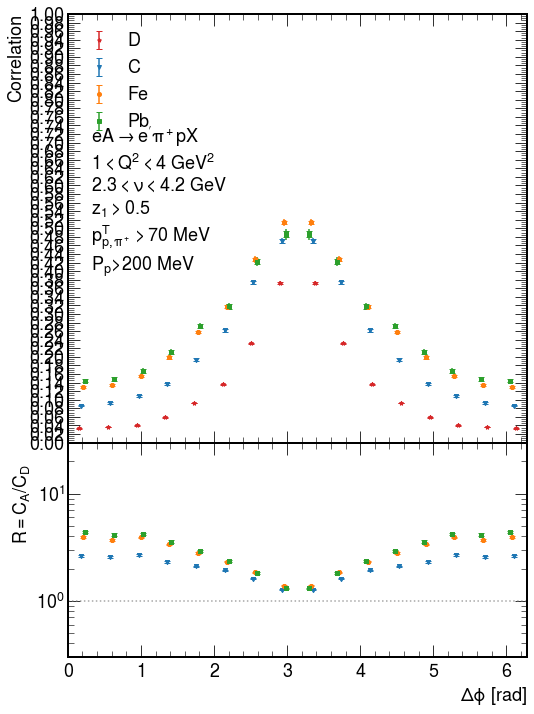

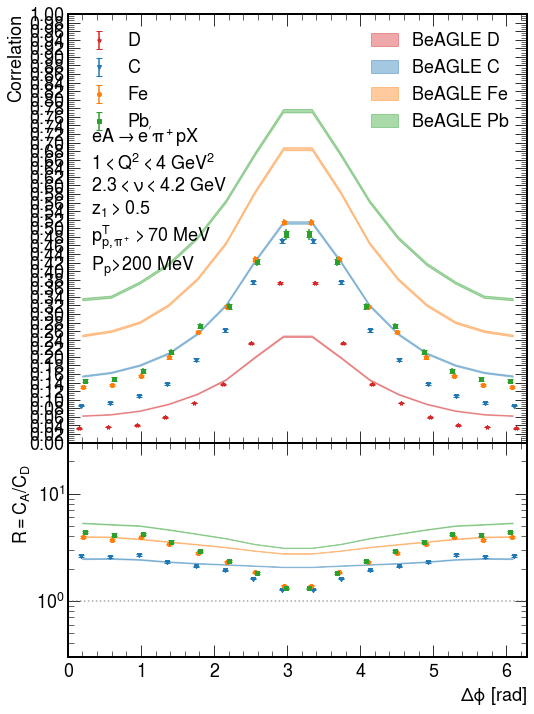

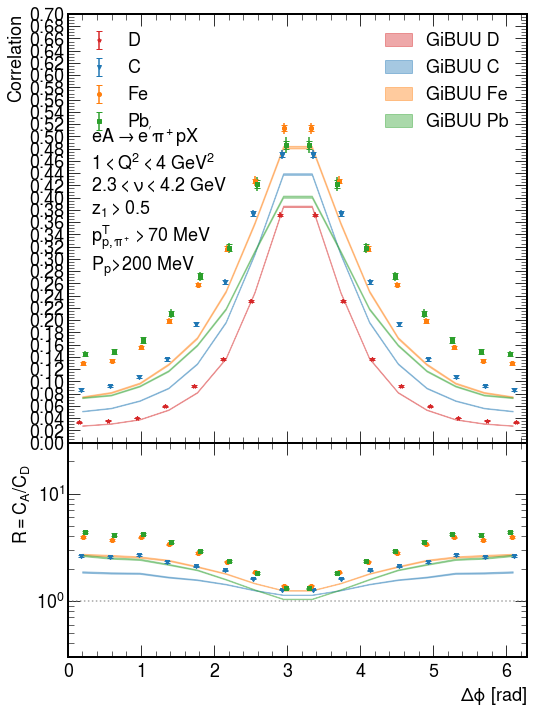

In [169]:
data, _, sliceinfo = get_values(None,  pThetaCutsGiBUU=True,GiBUU_suffix=None, pMin=0.3,pT1min=0.07, pT2min=0.07)
data_corr = [d for d in data]
data_corr = [apply_endcap_corrections(d) for d in data]
add_syst_error_from_misid(data_corr, 'all')
#add_syst_error_from_cuts(data_corr, 'all')
#add_syst_error_from_coulomb(data_corr, 'all')
#data_corr=add_syst_from_mixing(data_corr, 'all')
#add_syst_from_fbw(data_corr)
all_data_uncorr['all']=data
all_data['all']=data_corr
#all_GiBUU['all']=GiBUU
#print(sum(all_data['all'][0]['D'].C)*2*np.pi/8)

#replace the D calculations with the tweaked
#GiBUU[0]['D']=GiBUU[0]['D_tweak']
all_sliceinfo['all'] = sliceinfo
ymax=(1.0, 12)
#make_plots_new(normalize(data_corr), normalize(pred_BeAGLE['all']), sliceinfo, filename_tag="all", ymax=ymax)
make_plots_new(normalize(data_corr,2), None, sliceinfo, filename_tag="all", ymax=ymax)
make_plots_new(normalize(data_corr,2), normalize(pred_BeAGLE['all'],2), sliceinfo, filename_tag="all", ymax=ymax,
              prediction_name="BeAGLE")
make_plots_new(normalize(data_corr,2), normalize(pred_GiBUU['all'],2), sliceinfo, filename_tag="all", ymax=(0.7, 12),
              prediction_name="GiBUU")
print({A:sum(data_corr[0][A]['N2h']/data_corr[0][A+"_N1"]) for A in "D C Fe Pb".split()})


dnewIntegral= 0.0005479090295092493
systematic error on width from endcap: 0.007275657670498435
dnewIntegral= 0.0014243338619099029
systematic error on width from endcap: 0.00886004097129355
dnewIntegral= 0.0021045072173832735
systematic error on width from endcap: 0.006416214285338544
dnewIntegral= 0.002045531786383676
systematic error on width from endcap: 0.002766732881274284
dnewIntegral= 0.0014511243804793386
systematic error on width from endcap: 0.0004820316465415434
dnewIntegral= 0.0009152357589286231
systematic error on width from endcap: 0.00016978772606368652
saving to /home/sebouh/Documents/Overleaf_git/PionProtonAN/figures/results/main//corr_dY_GiBUU.pdf


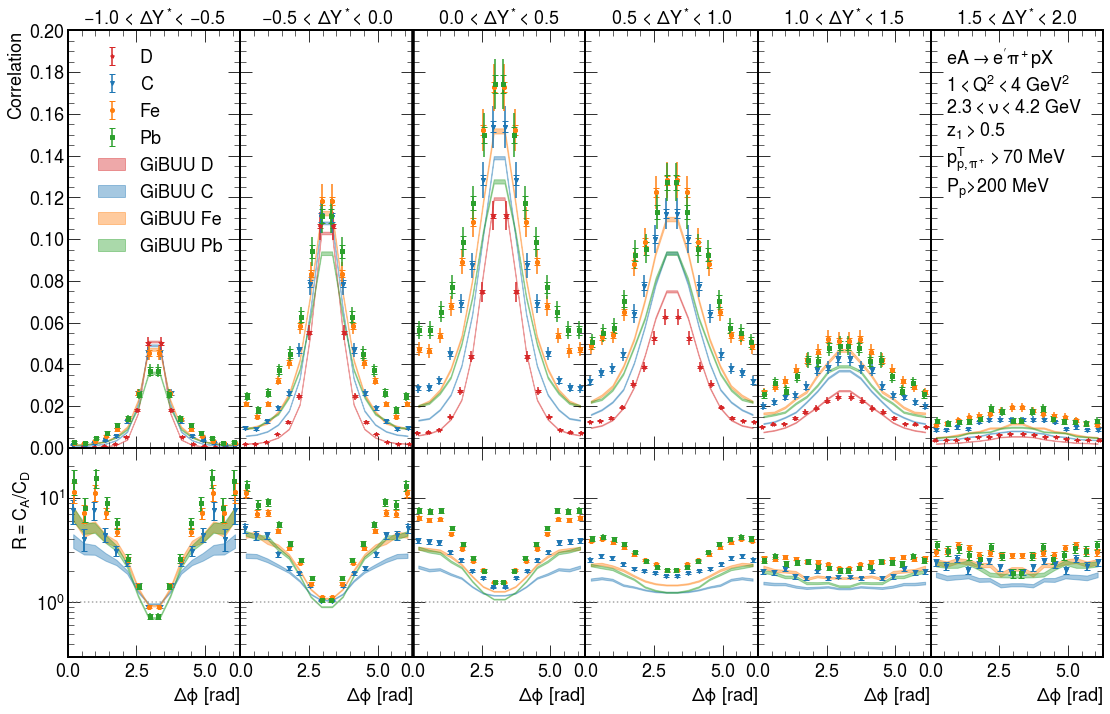

In [170]:
#data, GiBUU, sliceinfo = get_values("drap", "\Delta Y", np.linspace(0,3, 6),GiBUU_suffix=None)
#data, _, sliceinfo = get_values("drap", "\Delta Y", np.linspace(0.4,2.4, 6),GiBUU_suffix=None, pMin=0.2,pT1min=0.07,pT2min=0.07)
data, _, sliceinfo = get_values("drap-ycm", "\Delta Y^*", np.linspace(-1.0, 2.0, 7),GiBUU_suffix=None, pMin=0.2,pT1min=0.07,pT2min=0.07)


data_corr = [d for d in data]
data_corr = [apply_endcap_corrections(d) for d in data]
add_syst_error_from_misid(data_corr, 'dY')
add_syst_error_from_cuts(data_corr, 'dY')
#add_syst_error_from_coulomb(data_corr, 'dY')
data_corr=add_syst_from_mixing(data_corr, "dY")
#add_syst_from_fbw(data_corr)

all_data_uncorr['dY']=data
all_data['dY']=data_corr
#all_GiBUU['dY']=GiBUU
all_sliceinfo['dY'] = sliceinfo

#print(data_corr[0]['D'].dCsyst/data_corr[0]['D'].C)

#arg=dict(ymax=(0.1, 40), legend_panel=0)
#make_plots_new(data_corr, pred_BeAGLE['dY'], sliceinfo, filename_tag='dY_no_norm', **arg)

arg=dict( legend_panel=4)
#make_plots_new(normalize(data_corr, 2), normalize(pred_BeAGLE['dY'],2), sliceinfo, filename_tag='dY', **arg,ymax=(0.24, 40),
#              prediction_name="BeAGLE")
make_plots_new(normalize(data_corr, 2), normalize(pred_GiBUU['dY'],2), sliceinfo, filename_tag='dY_GiBUU', **arg,ymax=(0.2, 40),
              prediction_name="GiBUU")
#make_plots_new(normalize(data_corr, 2), None, sliceinfo, filename_tag='dY', **arg,ymax=(0.24, 40))


In [171]:
#data, _, sliceinfo = get_values("drap-ycm", "\Delta Y^*", np.linspace(-1.0, 2.0, 7),GiBUU_suffix=None, pMin=0.2,pT1min=0.07,pT2min=0.07)
#make_plots_new(normalize(data, 2), None, sliceinfo, filename_tag='dY_extended', **arg,ymax=(0.24, 40))
#all_data['dY_extended']=data

In [172]:
table=""
for i in range(5):
    for j in range(8):
        dycuts=f"{-1+0.5*i:.1f}$-${-0.5+0.5*i:.1f}" if j == 0 else ""
        line=f"{dycuts} & {j*np.pi/8:.2f}$-${(j+1)*np.pi/8:.2f}"
        
        for A in "D C Fe Pb".split():
            C=all_data['dY'][i][A].C[j]
            stat=all_data['dY'][i][A].dCstat[j]
            syst=all_data['dY'][i][A].dCsyst[j]
            line = line+f"&${C:.3f}\\pm{stat:.3f}\\pm{syst:.3f}$"
        line+="\\\\\n"
        table+=line
    table+="\\hline\n"
print(table)
        

-1.0$-$-0.5 & 0.00$-$0.39&$0.000\pm0.000\pm0.000$&$0.002\pm0.000\pm0.000$&$0.002\pm0.000\pm0.000$&$0.003\pm0.001\pm0.000$\\
 & 0.39$-$0.79&$0.000\pm0.000\pm0.000$&$0.001\pm0.000\pm0.000$&$0.002\pm0.000\pm0.000$&$0.003\pm0.001\pm0.000$\\
 & 0.79$-$1.18&$0.000\pm0.000\pm0.000$&$0.002\pm0.000\pm0.000$&$0.003\pm0.000\pm0.000$&$0.005\pm0.001\pm0.000$\\
 & 1.18$-$1.57&$0.001\pm0.000\pm0.000$&$0.004\pm0.000\pm0.000$&$0.006\pm0.000\pm0.000$&$0.007\pm0.001\pm0.000$\\
 & 1.57$-$1.96&$0.002\pm0.000\pm0.000$&$0.006\pm0.000\pm0.000$&$0.009\pm0.001\pm0.001$&$0.011\pm0.001\pm0.001$\\
 & 1.96$-$2.36&$0.005\pm0.000\pm0.000$&$0.013\pm0.001\pm0.001$&$0.014\pm0.001\pm0.001$&$0.014\pm0.001\pm0.001$\\
 & 2.36$-$2.75&$0.018\pm0.000\pm0.001$&$0.026\pm0.001\pm0.002$&$0.026\pm0.001\pm0.002$&$0.026\pm0.002\pm0.002$\\
 & 2.75$-$3.14&$0.050\pm0.001\pm0.003$&$0.045\pm0.001\pm0.003$&$0.045\pm0.001\pm0.003$&$0.037\pm0.002\pm0.002$\\
\hline
-0.5$-$0.0 & 0.00$-$0.39&$0.002\pm0.000\pm0.000$&$0.010\pm0.001\pm0.001$&$0.02

In [173]:
table=""
for i in range(5):
    for j in range(8):
        dycuts=f"{-1+0.5*i:.1f}$-${-0.5+0.5*i:.1f}" if j == 0 else ""
        line=f"{dycuts} & {j*np.pi/8:.2f}$-${(j+1)*np.pi/8:.2f}"
        
        for A in "C Fe Pb".split():
            C=all_data['dY'][i][A].R[j]
            stat=all_data['dY'][i][A].dRstat[j]
            syst=all_data['dY'][i][A].dRsyst[j]
            line = line+f"&${C:.3f}\\pm{stat:.3f}\\pm{syst:.3f}$"
        line+="\\\\\n"
        table+=line
    table+="\\hline\n"
print(table)

-1.0$-$-0.5 & 0.00$-$0.39&$7.573\pm1.924\pm0.408$&$11.407\pm2.565\pm0.617$&$14.578\pm3.906\pm0.791$\\
 & 0.39$-$0.79&$4.034\pm0.952\pm0.181$&$7.166\pm1.386\pm0.325$&$7.909\pm1.984\pm0.363$\\
 & 0.79$-$1.18&$7.658\pm1.503\pm0.382$&$11.196\pm1.956\pm0.560$&$15.455\pm3.157\pm0.788$\\
 & 1.18$-$1.57&$4.446\pm0.636\pm0.175$&$7.074\pm0.856\pm0.282$&$8.863\pm1.337\pm0.365$\\
 & 1.57$-$1.96&$3.099\pm0.329\pm0.089$&$4.702\pm0.417\pm0.135$&$5.729\pm0.664\pm0.172$\\
 & 1.96$-$2.36&$2.369\pm0.165\pm0.048$&$2.552\pm0.162\pm0.054$&$2.620\pm0.246\pm0.057$\\
 & 2.36$-$2.75&$1.457\pm0.067\pm0.029$&$1.447\pm0.062\pm0.030$&$1.425\pm0.096\pm0.032$\\
 & 2.75$-$3.14&$0.906\pm0.031\pm0.018$&$0.907\pm0.028\pm0.019$&$0.737\pm0.041\pm0.017$\\
\hline
-0.5$-$0.0 & 0.00$-$0.39&$5.137\pm0.522\pm0.400$&$11.091\pm0.906\pm0.866$&$13.036\pm1.298\pm1.019$\\
 & 0.39$-$0.79&$4.361\pm0.409\pm0.173$&$7.056\pm0.557\pm0.283$&$8.583\pm0.853\pm0.349$\\
 & 0.79$-$1.18&$4.371\pm0.338\pm0.179$&$7.199\pm0.466\pm0.296$&$9.056\pm0.72

In [174]:
import pickle
with open("pion_proton_results.pkl", "wb") as f:
    pickle.dump(all_data, f, pickle.HIGHEST_PROTOCOL)

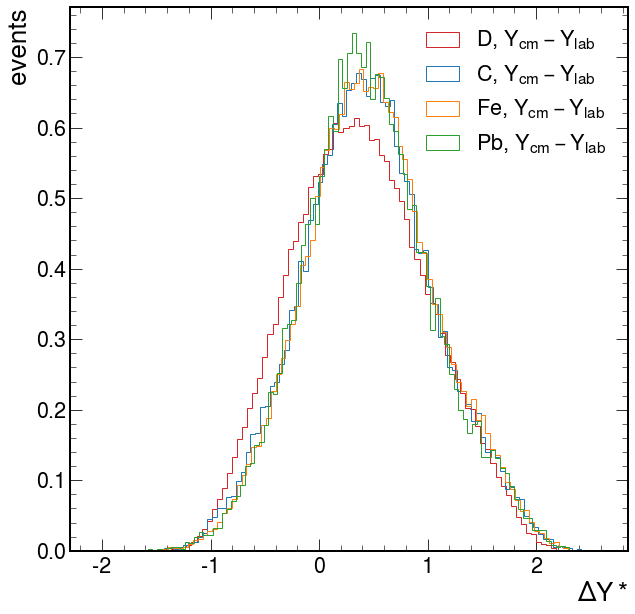

In [175]:
pT1min=0.07
pT2min=0.07
pMin=0.2

q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
colors='tab:red tab:blue tab:orange tab:green k'.split()
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'drap-ycm'
    #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
    plt.hist(dfs_pair[A].query(q).eval(expr), histtype='step', bins=100, density=True,
             color=colors[i], label=f'{A}, $Y_{{\\rm cm}}-Y_{{\\rm lab}}$')
plt.xlabel("$\Delta Y*$")
plt.ylabel("events")
plt.legend()

In [176]:
results={"data":all_data, "BeAGLE":pred_BeAGLE, "GiBUU":pred_GiBUU}

In [177]:
vals=np.array([])
for i in range(6):
    vals=np.concatenate([vals, np.abs(1-results['GiBUU']['dY'][i]['D'].C/results['data']['dY'][i]['D'].C)])
print(np.max(vals))
print(np.sqrt(np.mean(vals**2)))
print(np.median(vals))

vals=np.array([])
for A in "Pb".split():
    for i in range(6):
        vals=np.concatenate([vals, results['GiBUU']['dY'][i][A].C/results['data']['dY'][i][A].C])
print(np.min(vals),np.max(vals))
print(np.mean(vals))

0.4341434390002815
0.19049425088857364
0.14196193310324917
0.358274043955946 0.9748233554282286
0.5685354812878777


In [178]:
width_broadening_data={}

(12, 56, 208) [0.71742173 0.88209875 0.94744487] [0.00904029 0.00646675 0.00927542]
(12, 56, 208) [0.54390065 0.70003224 0.77050698] [0.00500604 0.004985   0.00442148]
(12, 56, 208) [0.39968245 0.56018659 0.68036835] [0.01435968 0.00990391 0.00811423]


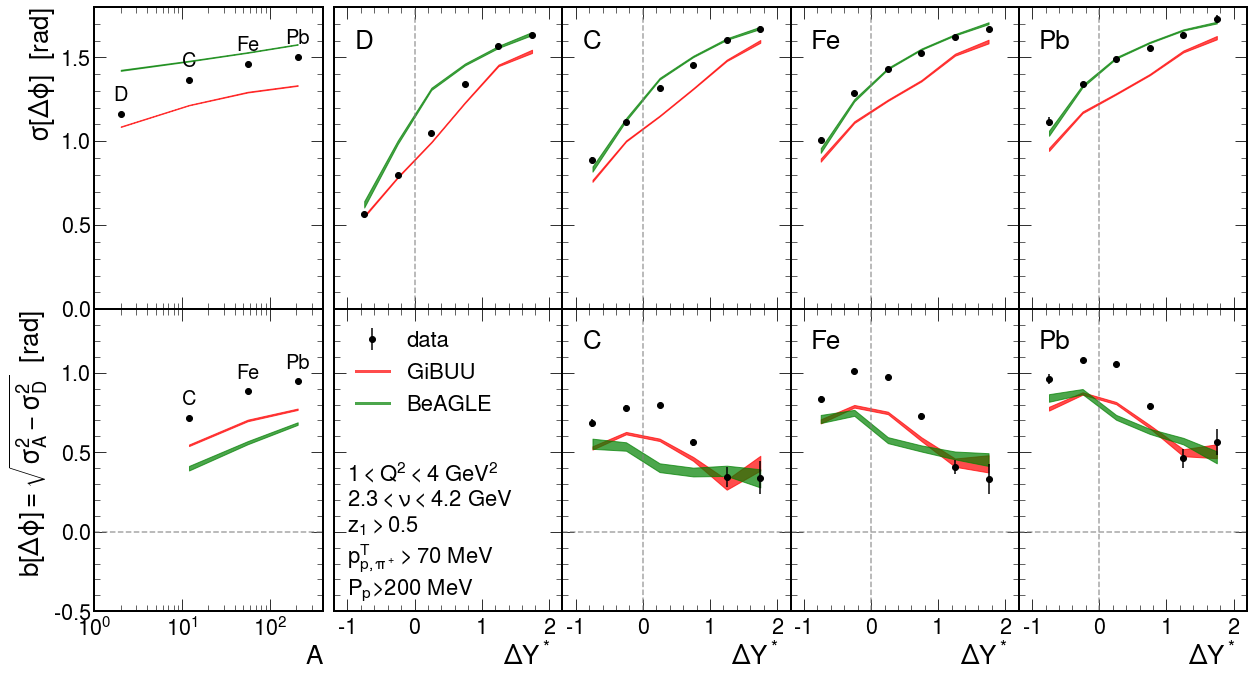

In [179]:

lbl_args=dict(fontsize=20, ha='center')
fig,axs=plt.subplots(2,6, figsize=(18,10), 
                     sharex='col', sharey='row', gridspec_kw=dict(width_ratios=(1,0.05, 1,1,1,1)))
axs[0][1].axis('off')
axs[1][1].axis('off')

colors={"GiBUU":"r", "BeAGLE":"g"}
#colors='tab:red tab:blue tab:orange tab:green'.split()

plt.sca(axs[0][0])
x=(2,12,56, 208)
plt.ylabel("$\\sigma[\Delta\phi]$  [rad]")
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 4e2)
#plt.ylim(0.5, 1.7)
sigmas_dPhi={}
dsigmas_dPhi={}
for res_set in "data",  "GiBUU", "BeAGLE":
    sigmas_dPhi[res_set]=[]
    dsigmas_dPhi[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        sigma=np.sqrt(sum(np.concatenate([results[res_set]['dY'][j][A].eval(f"C*(phi-{np.pi})**2") for j in range(6)]))/\
                     sum(np.concatenate([results[res_set]['dY'][j][A].C for j in range(6)])))
        sigmas_dPhi[res_set].append(sigma)
        C=np.concatenate([results[res_set]['dY'][j][A].C for j in range(6)])
        dCstat=np.concatenate([results[res_set]['dY'][j][A].dCstat for j in range(6)])
        bin_centers=np.concatenate([results[res_set]['dY'][j][A].phi for j in range(6)])
        dsigma=np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma)
        dsigmas_dPhi[res_set].append(dsigma)
        if res_set=="data":
            width_broadening_data[(A,"unbinned")]={"sigma":sigma,"dsigma":sigma}
    sigmas_dPhi[res_set]=np.array(sigmas_dPhi[res_set])
    if res_set=="data":
        plt.errorbar(x,sigmas_dPhi[res_set], dsigmas_dPhi[res_set], color='k', ls='', marker='o')
        for i,a in enumerate("D C Fe Pb".split()):
            plt.text(x[i],sigmas_dPhi[res_set][i]+.08, a, **lbl_args)
    else:
        plt.fill_between(x,sigmas_dPhi[res_set]- dsigmas_dPhi[res_set],sigmas_dPhi[res_set]+ dsigmas_dPhi[res_set], color=colors[res_set], ls='-', alpha=0.7)
    
plt.sca(axs[1][0])
for res_set in "data",  "GiBUU", "BeAGLE":
    b=np.array(sigmas_dPhi[res_set][1:])**2-sigmas_dPhi[res_set][0]**2
    b=b/np.sqrt(np.abs(b))

    db=np.hypot(sigmas_dPhi[res_set][1:]*dsigmas_dPhi[res_set][1:],sigmas_dPhi[res_set][0]*dsigmas_dPhi[res_set][0])/np.abs(b)
    if res_set=="data":
        for i, A in enumerate("C Fe Pb".split()):
            width_broadening_data[(A,"unbinned")].update({"b":b[i],"db":db[i]})
    print(x[1:],b, db)
    if res_set=="data":
        plt.errorbar(x[1:],b,db, color='k', ls='', marker='o', label='data')
        for i,a in enumerate("C Fe Pb".split()):
            plt.text(x[i+1],b[i]+.08, a, lbl_args)
    else:
        plt.fill_between(x[1:],b-db, b+db, color=colors[res_set], ls='-', alpha=0.7)
axs[1][0].set_xlabel("A")
plt.xlim(*axs[0][0].get_xlim())
plt.xscale("log")

#in bins of Delta Y*
for res_set in "data","GiBUU","BeAGLE":
    
    sigmas_dPhi={}
    dsigmas_dPhi={}
    for i, A in enumerate("D C Fe Pb".split()):
        expr = f'{np.pi}-dphi'
        #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
        Dybins=np.linspace(-1.0, 2.0, 7)
        sigmas_dPhi[A]=[]
        dsigmas_dPhi[A]=[]
        for j in range(len(Dybins)-1):
            sigma=np.sqrt(sum(results[res_set]['dY'][j][A].eval(f"C*(phi-{np.pi})**2"))/\
                         sum(results[res_set]['dY'][j][A].C))
            sigmas_dPhi[A].append(sigma)
            C=results[res_set]['dY'][j][A].C
            dCstat=results[res_set]['dY'][j][A].dCstat
            #print("dCstat",dCstat)
            bin_centers=results[res_set]['dY'][j][A].phi
            #print('bin_centers', bin_centers)
            dsigmas_dPhi[A].append(np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma))
            if res_set=="data":
                width_broadening_data[(A,j)]={"sigma":sigma,"dsigma":sigma}                       
        sigmas_dPhi[A]=np.array(sigmas_dPhi[A])
        #print('dsigmas',dsigmas_dPhi[A])
            #a=dfs_pair[A].query(q + f' and drap-ycm>{Dybins[j]} and drap-ycm<{Dybins[j+1]}').eval(expr)
            #x.append((Dybins[j]+Dybins[j+1])/2)
            #y.append(np.sqrt(np.mean(a**2)))
            #dy.append(np.std(a**2)/np.sqrt(len(a))/(2*y[-1]))
        plt.sca(axs[0][i+2])
        plt.ylim(0.0, 1.8)
        if res_set=='data':
            plt.text(-0.9, 1.55, A)
        x=(Dybins[1:]+Dybins[:-1])/2
        if res_set=='data':
            plt.errorbar(x,sigmas_dPhi[A],dsigmas_dPhi[A], color='k', ls='', marker='o')
        else:
            plt.fill_between(x,sigmas_dPhi[A]-dsigmas_dPhi[A],sigmas_dPhi[A]+dsigmas_dPhi[A], color=colors[res_set], alpha=0.7)
        
        plt.xlim(-1.2, 2.2)
        plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
        #if i ==0:
        #    y_D=np.array(sigmas_dPhi[A])
        #    dy_d=np.array(dsigmas_dPhi[A])
        #else:
        if i!=0:
            plt.sca(axs[1][i+2])
            plt.ylim(-.5, 1.4)
            plt.xlim(-1.2, 2.2)
            plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
            if res_set=='data':
                plt.text(-0.9, 1.15, A)
            
            
            b=sigmas_dPhi[A]**2-sigmas_dPhi['D']**2
            b=b/np.sqrt(np.abs(b))
            db=np.hypot(dsigmas_dPhi[A]*sigmas_dPhi[A],dsigmas_dPhi['D']*sigmas_dPhi['D'])/np.abs(b)
            if res_set=="data":
                for j in range(len(b)):
                    width_broadening_data[(A,j)].update({"b":b[j],"db":db[j]})
            if res_set=='data':
                plt.errorbar(x,b,db, color='k', ls='', marker='o')
            else:
                plt.fill_between(x,b-db, b+db, color=colors[res_set], alpha=0.7)
            
for i in range(4):
    axs[1][i+2].set_xlabel("$\\Delta Y^*$  ")
    axs[0][i+2].axvline(0, ls='--', alpha=0.7, color='0.5')

for i in range(1,4):
    axs[1][i+2].axhline(0, ls='--', alpha=0.7, color='0.5')
    axs[1][i+2].axvline(0, ls='--', alpha=0.7, color='0.5')
axs[1][0].axhline(0, ls='--', alpha=0.7, color='0.5')
    
axs[0][0].set_ylabel("$\\sigma[\\Delta\\phi]$  [rad]")
axs[1][0].set_ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$  [rad]")

#now make the legend in the empty panel
plt.sca(axs[1][2])
plt.ylim(-.5, 1.4)
plt.xlim(-1.2, 2.2)
plt.errorbar([],[],[], color='k', ls='', marker='o', label='data')
for res_set in "GiBUU", "BeAGLE":
    plt.errorbar([],[], color=colors[res_set], label=res_set, ls='-', lw='3', alpha=0.7)
plt.legend(fontsize=22, loc='upper left')
cuts_txt="$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>200 MeV"
plt.text(-1,-0.4, cuts_txt, fontsize=22)
#plt.gca().axis('off')

#axs[0][2].set_xlabel("$\Delta Y^*$  ")
#axs[1][2].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("images/pi_p_widths_broadenings.pdf")
plt.show()

In [54]:
table=""
for row in "unbinned",0,1,2,3,4,5:
    if row=="unbinned":
        dycuts=f"{-1:.1f}$-${2.0:.1f}"
    else:
        dycuts=f"{-1+0.5*row:.1f}$-${-0.5+0.5*row:.1f}"
    line=f"{dycuts} "
    
    for A in "D C Fe Pb".split():
        s=width_broadening_data[(A, row)]['sigma']
        stat=width_broadening_data[(A, row)]['dsigma']
        syst=0#width_broadening_data[(A, row)]['dsigma']
        line = line+f"&${s:.3f}\\pm{stat:.3f}\\pm{syst:.3f}$"
    line+="\\\\\n"
    table+=line
    if row=="unbinned":
        table+="\\hline\n"
table+="\\hline\n"
print(table)

-1.0$-$2.0 &$1.162\pm1.162\pm0.000$&$1.365\pm1.365\pm0.000$&$1.459\pm1.459\pm0.000$&$1.499\pm1.499\pm0.000$\\
\hline
-1.0$-$-0.5 &$0.567\pm0.567\pm0.000$&$0.889\pm0.889\pm0.000$&$1.009\pm1.009\pm0.000$&$1.118\pm1.118\pm0.000$\\
-0.5$-$0.0 &$0.798\pm0.798\pm0.000$&$1.117\pm1.117\pm0.000$&$1.286\pm1.286\pm0.000$&$1.341\pm1.341\pm0.000$\\
0.0$-$0.5 &$1.048\pm1.048\pm0.000$&$1.316\pm1.316\pm0.000$&$1.430\pm1.430\pm0.000$&$1.487\pm1.487\pm0.000$\\
0.5$-$1.0 &$1.338\pm1.338\pm0.000$&$1.452\pm1.452\pm0.000$&$1.525\pm1.525\pm0.000$&$1.554\pm1.554\pm0.000$\\
1.0$-$1.5 &$1.567\pm1.567\pm0.000$&$1.605\pm1.605\pm0.000$&$1.620\pm1.620\pm0.000$&$1.634\pm1.634\pm0.000$\\
1.5$-$2.0 &$1.633\pm1.633\pm0.000$&$1.668\pm1.668\pm0.000$&$1.666\pm1.666\pm0.000$&$1.728\pm1.728\pm0.000$\\
\hline



In [55]:
table=""
for row in "unbinned",0,1,2,3,4,5:
    if row=="unbinned":
        dycuts=f"{-1:.1f}$-${2.0:.1f}"
    else:
        dycuts=f"{-1+0.5*row:.1f}$-${-0.5+0.5*row:.1f}"
    line=f"{dycuts} "
    
    for A in "C Fe Pb".split():
        #print(A, row, width_broadening_data[(A, row)])
        b=width_broadening_data[(A, row)]['b']
        stat=width_broadening_data[(A, row)]['db']
        syst=0#width_broadening_data[(A, row)]['dsigma']
        line = line+f"&${b:.3f}\\pm{stat:.3f}\\pm{syst:.3f}$"
    line+="\\\\\n"
    table+=line
    if row=="unbinned":
        table+="\\hline\n"
table+="\\hline\n"
print(table)

-1.0$-$2.0 &$0.717\pm0.009\pm0.000$&$0.882\pm0.006\pm0.000$&$0.947\pm0.009\pm0.000$\\
\hline
-1.0$-$-0.5 &$0.684\pm0.023\pm0.000$&$0.834\pm0.019\pm0.000$&$0.963\pm0.031\pm0.000$\\
-0.5$-$0.0 &$0.781\pm0.015\pm0.000$&$1.008\pm0.011\pm0.000$&$1.078\pm0.016\pm0.000$\\
0.0$-$0.5 &$0.796\pm0.014\pm0.000$&$0.973\pm0.010\pm0.000$&$1.055\pm0.014\pm0.000$\\
0.5$-$1.0 &$0.562\pm0.024\pm0.000$&$0.731\pm0.016\pm0.000$&$0.789\pm0.022\pm0.000$\\
1.0$-$1.5 &$0.345\pm0.060\pm0.000$&$0.409\pm0.043\pm0.000$&$0.462\pm0.058\pm0.000$\\
1.5$-$2.0 &$0.340\pm0.105\pm0.000$&$0.332\pm0.092\pm0.000$&$0.566\pm0.082\pm0.000$\\
\hline



(array([ 3002., 16338., 29015., 35441., 27929., 13697.,  6410.,  2710.,
          948.,   197.]),
 array([1.03611371, 1.08122223, 1.12633076, 1.17143928, 1.21654781,
        1.26165633, 1.30676485, 1.35187338, 1.3969819 , 1.44209043,
        1.48719895]),
 <BarContainer object of 10 artists>)

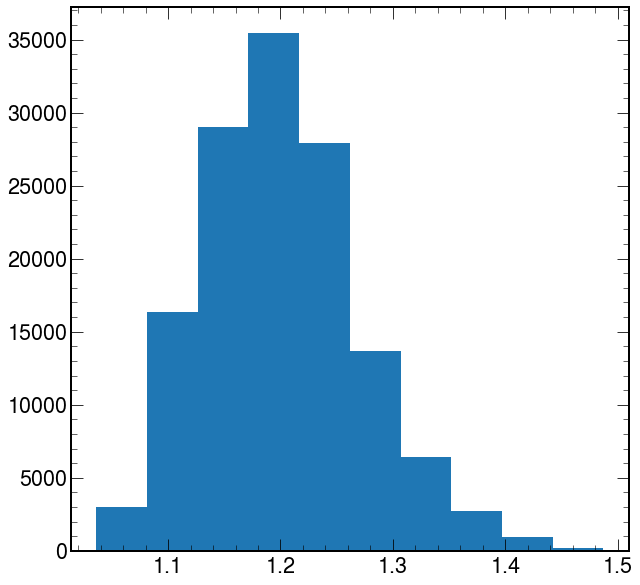

In [104]:
plt.hist(dfs_pair['D'].query(f"h1_pid==211   and h1_cm_pt > 0.07 and "+\
                 f"h2_cm_pt > 0.07 and h1_z>0.5 and h2_pid==2212 and h2_p>0.2 and pass_proton_TOF_cut").ycm)

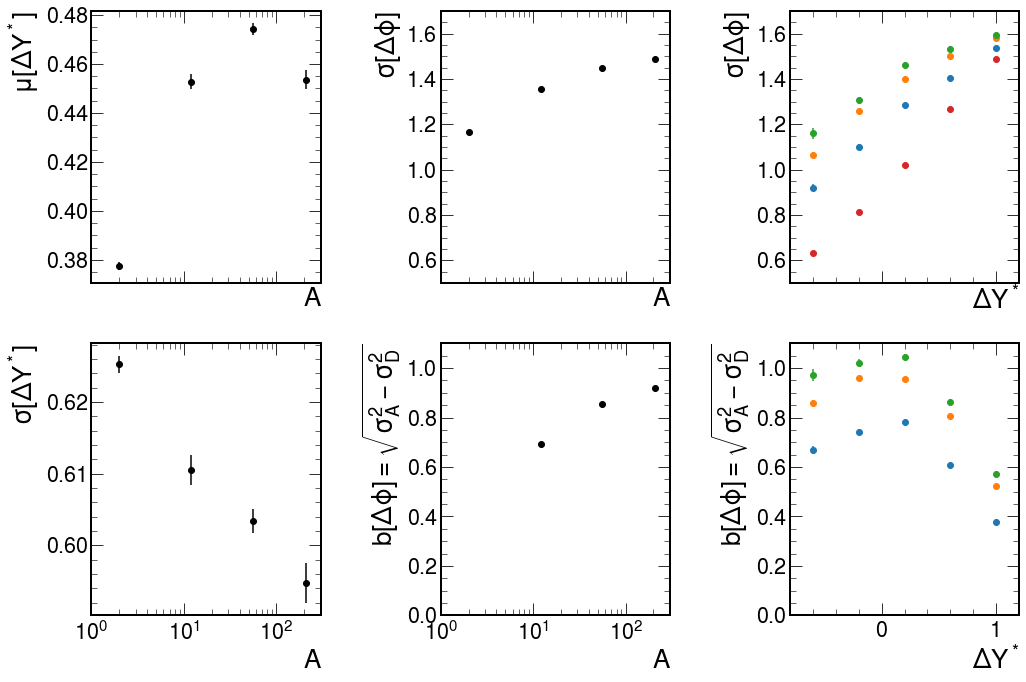

In [57]:
pT1min=0.07
pT2min=0.07
pMin=0.2

q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
colors='tab:red tab:blue tab:orange tab:green k'.split()
fig,axs=plt.subplots(2,3, figsize=(15,10), sharex='col')
x=(2,12,56, 208)
y=[]
dy=[]
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'drap-ycm'
    #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
    a=dfs_pair[A].query(q).eval(expr)
    y.append(np.mean(a))
    dy.append(np.std(a)/np.sqrt(len(a)))
plt.sca(axs[0][0])
plt.errorbar(x,y,dy, color='k', ls='', marker='o')
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylabel("$\mu[\\Delta Y^*$]")
x=(2,12,56, 208)
y=[]
dy=[]
for i, A in enumerate("D C Fe Pb".split()):
    expr = 'drap-ycm'
    #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
    a=dfs_pair[A].query(q).eval(expr)
    y.append(np.std(a))
    dy.append(np.std(a)/np.sqrt(2*len(a)))
plt.sca(axs[1][0])
plt.errorbar(x,y,dy, color='k', ls='', marker='o')
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylabel("$\\sigma[\\Delta Y^*]$")

x=(2,12,56, 208)
y=[]
dy=[]
for i, A in enumerate("D C Fe Pb".split()):
    expr = f'{np.pi}-dphi'
    #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
    a=dfs_pair[A].query(q).eval(expr)
    y.append(np.sqrt(np.mean(a**2)))
    dy.append(np.std(a**2)/np.sqrt(len(a))/(2*y[-1]))
plt.sca(axs[0][1])
plt.errorbar(x,y,dy, color='k', ls='', marker='o')
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylabel("$\\sigma[\Delta\phi]$")
plt.ylim(0.5, 1.7)

plt.sca(axs[1][1])
plt.errorbar(x[1:],np.sqrt(np.array(y[1:])**2-y[0]**2),dy[1:], color='k', ls='', marker='o')
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylim(0.0, 1.1)
plt.ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$")

colors='tab:red tab:blue tab:orange tab:green'.split()
plt.sca(axs[0][1])
for i, A in enumerate("D C Fe Pb".split()):
    expr = f'{np.pi}-dphi'
    #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
    Dybins=np.linspace(-0.8, 1.2, 6)
    y=[]
    dy=[]
    x=[]
    for j in range(len(Dybins)-1):
        a=dfs_pair[A].query(q + f' and drap-ycm>{Dybins[j]} and drap-ycm<{Dybins[j+1]}').eval(expr)
        x.append((Dybins[j]+Dybins[j+1])/2)
        y.append(np.sqrt(np.mean(a**2)))
        dy.append(np.std(a**2)/np.sqrt(len(a))/(2*y[-1]))
    plt.sca(axs[0][2])
    plt.errorbar(x,y,dy, color=colors[i], ls='', marker='o')
    if i ==0:
        y_D=np.array(y)
        dy_d=np.array(dy)
    else:
        plt.sca(axs[1][2])
        plt.errorbar(x,np.sqrt(np.array(y)**2-y_D**2),dy, color=colors[i], ls='', marker='o')

plt.sca(axs[0][2])
plt.xlabel("$\\Delta Y^*$")
plt.ylabel("$\\sigma[\Delta\phi]$")
plt.ylim(0.5, 1.7)

plt.sca(axs[1][2])
plt.xlabel("$\\Delta Y^*$")
plt.ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$")
plt.xlim(-0.8, 1.2)
plt.ylim(0, 1.1)

plt.tight_layout()

(12, 56, 208) [0.69076366 0.85173901 0.92195115] [0.00985179 0.00711237 0.01029918]
(12, 56, 208) [0.54622727 0.70430737 0.77472415] [0.00488468 0.00484103 0.00430326]
(12, 56, 208) [-0.18394501  0.36013117  0.53244965] [0.05088484 0.02459348 0.01609267]


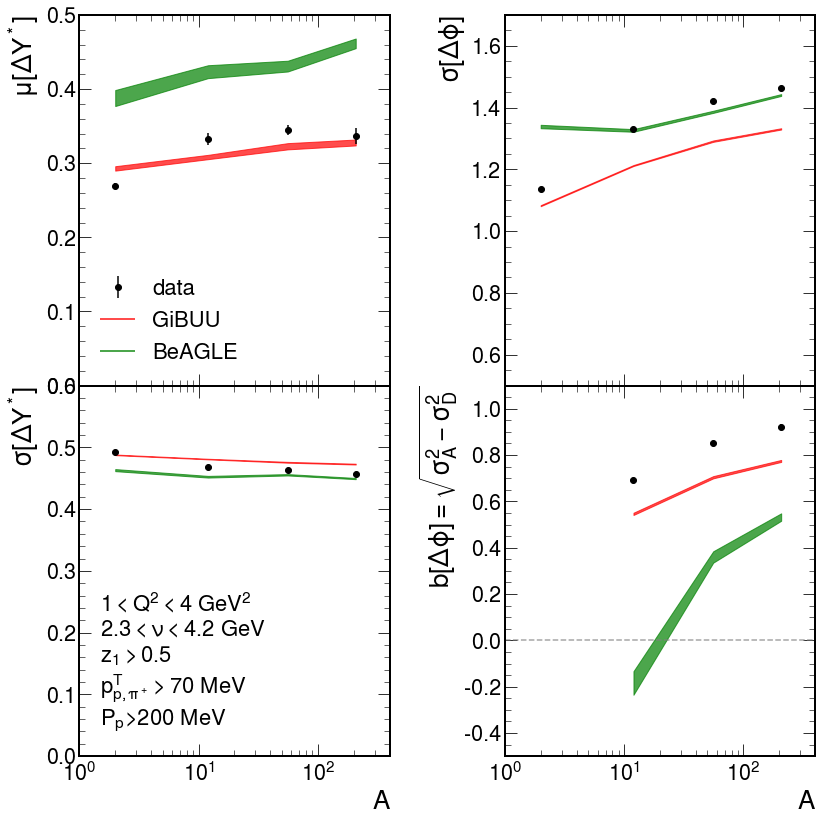

In [213]:
pT1min=0.07
pT2min=0.07
pMin=0.2

q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
colors={"GiBUU":"r", "BeAGLE":"g"}
fig,axs=plt.subplots(2,2, figsize=(12,12), sharex='all')

x=(2,12,56, 208)
mus={}
dmus={}
for res_set in "data",  "GiBUU", "BeAGLE":
    mus[res_set]=[]
    dmus[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        
        mus[res_set].append(sum([sum(results[res_set]['dY'][k][A].C)*(-.6+.4*k) for k in range(5)])/\
                     sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
        dmus[res_set].append(np.sqrt(sum([(sum(results[res_set]['dY'][k][A].dCstat)*(-.6+.4*k))**2 for k in range(5)]))/\
                     sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
    plt.sca(axs[0][0])
    mus[res_set]=np.array(mus[res_set])
    if res_set == "data":
        plt.errorbar(x,mus[res_set], dmus[res_set], color='k', ls='', marker='o')
    else:
        plt.fill_between(x,mus[res_set]- dmus[res_set],mus[res_set]+ dmus[res_set] , color=colors[res_set], ls='-', alpha=0.7)

#plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylim(0, 0.5)
plt.ylabel("$\mu[\\Delta Y^*$]")

#standard deviation of ΔΥ*
plt.sca(axs[1][0])
x=(2,12,56, 208)
sigmas={}
dsigmas={}
for res_set in "data",  "GiBUU", "BeAGLE":
    sigmas[res_set]=[]
    dsigmas[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        bin_centers=np.array([-.6+.4*k for k in range(5)])
        sigma=np.sqrt(sum([sum(results[res_set]['dY'][k][A].C)*(bin_centers[k]-mus[res_set][i])**2 for k in range(5)])/\
                     sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
        sigmas[res_set].append(sigma)
        C=np.array([sum(results[res_set]['dY'][k][A].C) for k in range(5)])
        dCstat=np.sqrt(np.array([sum(results[res_set]['dY'][k][A].dCstat**2) for k in range(5)]))
        dsigma=np.sqrt(sum(dCstat**2*(((bin_centers-mus[res_set][i])**2-sigma**2)/sum(C))**2))/(2*sigma)
        dsigmas[res_set].append(dsigma)
    
    sigmas[res_set]=np.array(sigmas[res_set])
    if res_set=="data":
        plt.errorbar(x,sigmas[res_set], dsigmas[res_set], color='k', ls='', marker='o')
    else:
        plt.fill_between(x,sigmas[res_set]- dsigmas[res_set],sigmas[res_set]+ dsigmas[res_set], color=colors[res_set], ls='-', alpha=0.7)
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylim(0, 0.6)
plt.ylabel("$\\sigma[\\Delta Y^*]$")

#standard deviation of Δφ
plt.sca(axs[0][1])
x=(2,12,56, 208)
plt.ylabel("$\\sigma[\Delta\phi]$")
#plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylim(0.5, 1.7)
sigmas_dPhi={}
dsigmas_dPhi={}
for res_set in "data",  "GiBUU", "BeAGLE":
    sigmas_dPhi[res_set]=[]
    dsigmas_dPhi[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        sigma=np.sqrt(sum(results[res_set]['all'][0][A].eval(f"C*(phi-{np.pi})**2"))/\
                     sum(results[res_set]['all'][0][A].C))
        sigmas_dPhi[res_set].append(sigma)
        C=results[res_set]['all'][0][A].C
        dCstat=results[res_set]['all'][0][A].dCstat
        bin_centers=results[res_set]['all'][0][A].phi
        dsigmas_dPhi[res_set].append(np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma))
    sigmas_dPhi[res_set]=np.array(sigmas_dPhi[res_set])
    if res_set=="data":
        plt.errorbar(x,sigmas_dPhi[res_set], dsigmas_dPhi[res_set], color='k', ls='', marker='o')
    else:
        plt.fill_between(x,sigmas_dPhi[res_set]- dsigmas_dPhi[res_set],sigmas_dPhi[res_set]+ dsigmas_dPhi[res_set], color=colors[res_set], ls='-', alpha=0.7)

#broadening in Δφ
plt.sca(axs[1][1])
for res_set in "data",  "GiBUU", "BeAGLE":
    b=np.array(sigmas_dPhi[res_set][1:])**2-sigmas_dPhi[res_set][0]**2
    b=b/np.sqrt(np.abs(b))

    db=np.hypot(sigmas_dPhi[res_set][1:]*dsigmas_dPhi[res_set][1:],sigmas_dPhi[res_set][0]*dsigmas_dPhi[res_set][0])/np.abs(b)
    print(x[1:],b, db)
    if res_set=="data":
        plt.errorbar(x[1:],b,db, color='k', ls='', marker='o', label='data')
    else:
        plt.fill_between(x[1:],b-db, b+db, color=colors[res_set], ls='-', alpha=0.7)
axs[1][1].axhline(0, ls='--', alpha=0.7, color='0.5')
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 4e2)
plt.ylim(-0.5, 1.1)
plt.ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$")

## dummy for the legend
axs[0][0].errorbar([],[], [], ls='', marker='o', label='data', color='k')
axs[0][0].errorbar([],[], ls='-', lw=2, color=colors['GiBUU'], alpha=0.7, label='GiBUU')
axs[0][0].errorbar([],[], ls='-', lw=2, color=colors['BeAGLE'], alpha=0.7, label='BeAGLE')
axs[0][0].legend(loc='lower left', fontsize=22)

cuts_txt="$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>200 MeV"
axs[1][0].text(1.5,0.05, cuts_txt, fontsize=22)
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

(12, 56, 208) [0.69076366 0.85173901 0.92195115] [0.00985179 0.00711237 0.01029918]
(12, 56, 208) [0.54622727 0.70430737 0.77472415] [0.00488468 0.00484103 0.00430326]
(12, 56, 208) [-0.18394501  0.36013117  0.53244965] [0.05088484 0.02459348 0.01609267]


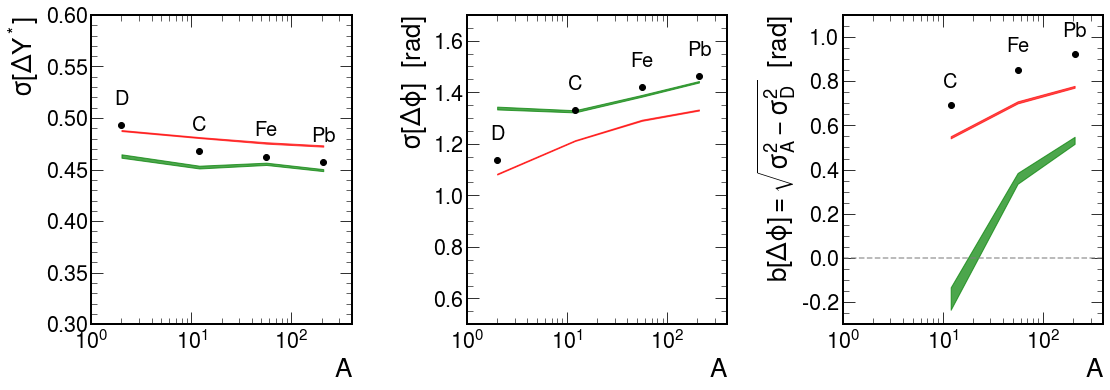

In [321]:
pT1min=0.07
pT2min=0.07
pMin=0.2

q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
colors={"GiBUU":"r", "BeAGLE":"g"}
fig,axs=plt.subplots(1,3, figsize=(16,6), sharex='all')

# x=(2,12,56, 208)
# mus={}
# dmus={}
# for res_set in "data",  "GiBUU", "BeAGLE":
#     mus[res_set]=[]
#     dmus[res_set]=[]
#     for i, A in enumerate("D C Fe Pb".split()):
        
#         mus[res_set].append(sum([sum(results[res_set]['dY'][k][A].C)*(-.6+.4*k) for k in range(5)])/\
#                      sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
#         dmus[res_set].append(np.sqrt(sum([(sum(results[res_set]['dY'][k][A].dCstat)*(-.6+.4*k))**2 for k in range(5)]))/\
#                      sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
#     plt.sca(axs[0][0])
#     mus[res_set]=np.array(mus[res_set])
#     if res_set == "data":
#         plt.errorbar(x,mus[res_set], dmus[res_set], color='k', ls='', marker='o')
#     else:
#         plt.fill_between(x,mus[res_set]- dmus[res_set],mus[res_set]+ dmus[res_set] , color=colors[res_set], ls='-', alpha=0.7)

# #plt.xlabel("A")
# plt.xscale('log')
# plt.xlim(1, 3e2)
# plt.ylim(0, 0.5)
# plt.ylabel("$\mu[\\Delta Y^*$]")
lbl_args=dict(fontsize=20, ha='center')
#standard deviation of ΔΥ*
plt.sca(axs[0])
x=(2,12,56, 208)
sigmas={}
dsigmas={}
mus={}
dmus={}
for res_set in "data",  "GiBUU", "BeAGLE":
    mus[res_set]=[]
    dmus[res_set]=[]
    sigmas[res_set]=[]
    dsigmas[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        bin_centers=np.array([-.6+.4*k for k in range(5)])
        mus[res_set].append(sum([sum(results[res_set]['dY'][k][A].C)*(-.6+.4*k) for k in range(5)])/\
                     sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
        dmus[res_set].append(np.sqrt(sum([(sum(results[res_set]['dY'][k][A].dCstat)*(-.6+.4*k))**2 for k in range(5)]))/\
                     sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
        sigma=np.sqrt(sum([sum(results[res_set]['dY'][k][A].C)*(bin_centers[k]-mus[res_set][i])**2 for k in range(5)])/\
                     sum([sum(results[res_set]['dY'][k][A].C) for k in range(5)]))
        sigmas[res_set].append(sigma)
        C=np.array([sum(results[res_set]['dY'][k][A].C) for k in range(5)])
        dCstat=np.sqrt(np.array([sum(results[res_set]['dY'][k][A].dCstat**2) for k in range(5)]))
        dsigma=np.sqrt(sum(dCstat**2*(((bin_centers-mus[res_set][i])**2-sigma**2)/sum(C))**2))/(2*sigma)
        dsigmas[res_set].append(dsigma)
    
    sigmas[res_set]=np.array(sigmas[res_set])
    if res_set=="data":
        plt.errorbar(x,sigmas[res_set], dsigmas[res_set], color='k', ls='', marker='o')
        for i,a in enumerate("D C Fe Pb".split()):
            plt.text(x[i],sigmas[res_set][i]+.02, a, **lbl_args)
    else:
        plt.fill_between(x,sigmas[res_set]- dsigmas[res_set],sigmas[res_set]+ dsigmas[res_set], color=colors[res_set], ls='-', alpha=0.7)
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylim(0.3, 0.6)
plt.ylabel("$\\sigma[\\Delta Y^*]$")

#standard deviation of Δφ
plt.sca(axs[1])
x=(2,12,56, 208)
plt.ylabel("$\\sigma[\Delta\phi]$  [rad]")
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 3e2)
plt.ylim(0.5, 1.7)
sigmas_dPhi={}
dsigmas_dPhi={}
for res_set in "data",  "GiBUU", "BeAGLE":
    sigmas_dPhi[res_set]=[]
    dsigmas_dPhi[res_set]=[]
    for i, A in enumerate("D C Fe Pb".split()):
        sigma=np.sqrt(sum(results[res_set]['all'][0][A].eval(f"C*(phi-{np.pi})**2"))/\
                     sum(results[res_set]['all'][0][A].C))
        sigmas_dPhi[res_set].append(sigma)
        C=results[res_set]['all'][0][A].C
        dCstat=results[res_set]['all'][0][A].dCstat
        bin_centers=results[res_set]['all'][0][A].phi
        dsigmas_dPhi[res_set].append(np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma))
    sigmas_dPhi[res_set]=np.array(sigmas_dPhi[res_set])
    if res_set=="data":
        plt.errorbar(x,sigmas_dPhi[res_set], dsigmas_dPhi[res_set], color='k', ls='', marker='o')
        for i,a in enumerate("D C Fe Pb".split()):
            plt.text(x[i],sigmas_dPhi[res_set][i]+.08, a, **lbl_args)
    else:
        plt.fill_between(x,sigmas_dPhi[res_set]- dsigmas_dPhi[res_set],sigmas_dPhi[res_set]+ dsigmas_dPhi[res_set], color=colors[res_set], ls='-', alpha=0.7)

#broadening in Δφ
plt.sca(axs[2])
for res_set in "data",  "GiBUU", "BeAGLE":
    b=np.array(sigmas_dPhi[res_set][1:])**2-sigmas_dPhi[res_set][0]**2
    b=b/np.sqrt(np.abs(b))

    db=np.hypot(sigmas_dPhi[res_set][1:]*dsigmas_dPhi[res_set][1:],sigmas_dPhi[res_set][0]*dsigmas_dPhi[res_set][0])/np.abs(b)
    print(x[1:],b, db)
    if res_set=="data":
        plt.errorbar(x[1:],b,db, color='k', ls='', marker='o', label='data')
        for i,a in enumerate("C Fe Pb".split()):
            plt.text(x[i+1],b[i]+.08, a, lbl_args)
    else:
        plt.fill_between(x[1:],b-db, b+db, color=colors[res_set], ls='-', alpha=0.7)
axs[2].axhline(0, ls='--', alpha=0.7, color='0.5')
plt.xlabel("A")
plt.xscale('log')
plt.xlim(1, 4e2)
plt.ylim(-0.3, 1.1)
plt.ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$  [rad]")

# ## dummy for the legend
# axs[0][0].errorbar([],[], [], ls='', marker='o', label='data', color='k')
# axs[0][0].errorbar([],[], ls='-', lw=2, color=colors['GiBUU'], alpha=0.7, label='GiBUU')
# axs[0][0].errorbar([],[], ls='-', lw=2, color=colors['BeAGLE'], alpha=0.7, label='BeAGLE')
# axs[0][0].legend(loc='lower left', fontsize=22)

# cuts_txt="$1<Q^2<4$ GeV$^2$\n"+\
#                       "$2.3<\\nu<4.2$ GeV\n"+\
#                       "$z_1>0.5$\n"+\
#                       "$p_{p,\pi^+}^T>70$ MeV\n"+\
#                       "$P_p$>200 MeV"
# axs[1][0].text(1.5,0.05, cuts_txt, fontsize=22)
plt.tight_layout()
#plt.subplots_adjust(wspace=0.4)
plt.savefig("images/derived_quantities.pdf")
plt.show()

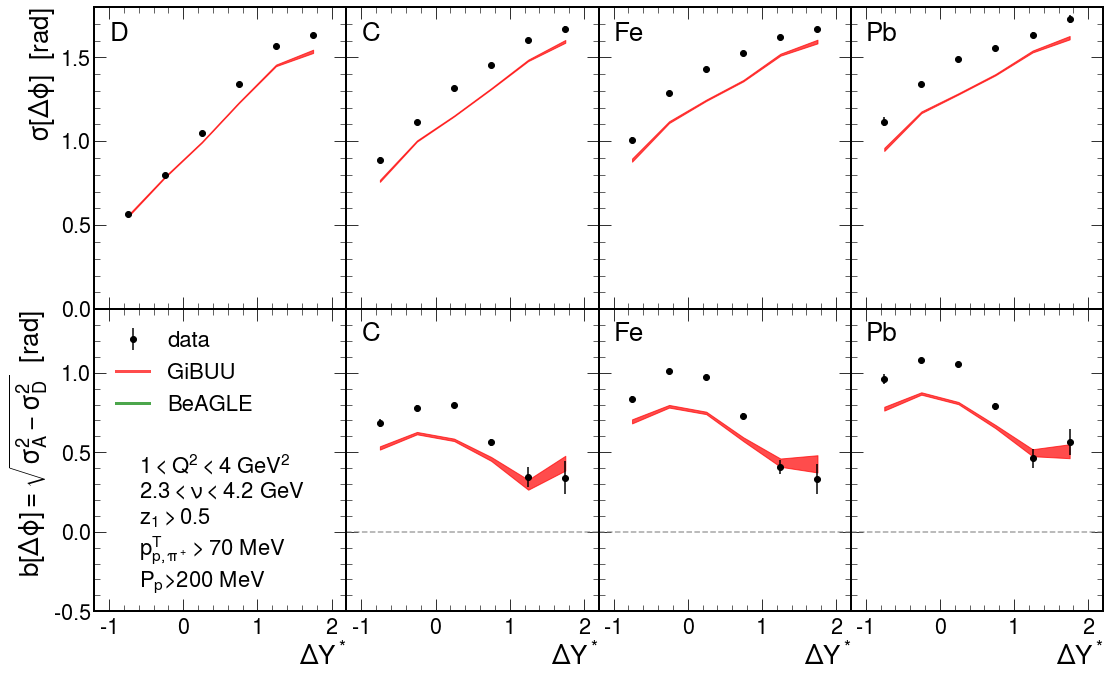

In [500]:

fig,axs=plt.subplots(2,4, figsize=(16,10), sharex='all', sharey='row')
colors={"GiBUU":"r", "BeAGLE":"g"}
#colors='tab:red tab:blue tab:orange tab:green'.split()
for res_set in "data","GiBUU":
    
    sigmas_dPhi={}
    dsigmas_dPhi={}
    for i, A in enumerate("D C Fe Pb".split()):
        expr = f'{np.pi}-dphi'
        #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
        Dybins=np.linspace(-1.0, 2.0, 7)
        sigmas_dPhi[A]=[]
        dsigmas_dPhi[A]=[]
        for j in range(len(Dybins)-1):
            sigma=np.sqrt(sum(results[res_set]['dY'][j][A].eval(f"C*(phi-{np.pi})**2"))/\
                         sum(results[res_set]['dY'][j][A].C))
            sigmas_dPhi[A].append(sigma)
            C=results[res_set]['dY'][j][A].C
            dCstat=results[res_set]['dY'][j][A].dCstat
            #print("dCstat",dCstat)
            bin_centers=results[res_set]['dY'][j][A].phi
            #print('bin_centers', bin_centers)
            dsigmas_dPhi[A].append(np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma))
                                   
        sigmas_dPhi[A]=np.array(sigmas_dPhi[A])
        #print('dsigmas',dsigmas_dPhi[A])
            #a=dfs_pair[A].query(q + f' and drap-ycm>{Dybins[j]} and drap-ycm<{Dybins[j+1]}').eval(expr)
            #x.append((Dybins[j]+Dybins[j+1])/2)
            #y.append(np.sqrt(np.mean(a**2)))
            #dy.append(np.std(a**2)/np.sqrt(len(a))/(2*y[-1]))
        plt.sca(axs[0][i])
        plt.ylim(0.0, 1.8)
        if res_set=='data':
            plt.text(-1, 1.6, A)
        x=(Dybins[1:]+Dybins[:-1])/2
        if res_set=='data':
            plt.errorbar(x,sigmas_dPhi[A],dsigmas_dPhi[A], color='k', ls='', marker='o')
        else:
            plt.fill_between(x,sigmas_dPhi[A]-dsigmas_dPhi[A],sigmas_dPhi[A]+dsigmas_dPhi[A], color=colors[res_set], alpha=0.7)
        if i ==0:
            y_D=np.array(y)
            dy_d=np.array(dy)
        else:
            plt.sca(axs[1][i])
            if res_set=='data':
                plt.text(-1, 1.2, A)
            
            
            b=sigmas_dPhi[A]**2-sigmas_dPhi['D']**2
            b=b/np.sqrt(np.abs(b))
            db=np.hypot(dsigmas_dPhi[A]*sigmas_dPhi[A],dsigmas_dPhi['D']*sigmas_dPhi['D'])/np.abs(b)
            if res_set=='data':
                plt.errorbar(x,b,db, color='k', ls='', marker='o')
            else:
                plt.fill_between(x,b-db, b+db, color=colors[res_set], alpha=0.7)
            plt.ylim(-.5, 1.4)
            plt.xlim(-1.2, 2.2)
            plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
for i in range(4):
    axs[1][i].set_xlabel("$\\Delta Y^*$")

for i in range(1,4):
    axs[1][i].axhline(0, ls='--', alpha=0.7, color='0.5')
    
axs[0][0].set_ylabel("$\\sigma[\\Delta\\phi]$  [rad]")
axs[1][0].set_ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$  [rad]")

#now make the legend in the lower left corner
axs[1][0].errorbar([],[],[], color='k', ls='', marker='o', label='data')
for res_set in "GiBUU", "BeAGLE":
    axs[1][0].errorbar([],[], color=colors[res_set], label=res_set, ls='-', lw='3', alpha=0.7)
axs[1][0].legend(fontsize=22, loc='upper left')
cuts_txt="$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>200 MeV"
axs[1][0].text(-0.6,-0.35, cuts_txt, fontsize=22)
#axs[1][0].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("images/pi_p_widths_broadenings.pdf")
plt.show()

8
8
8
8


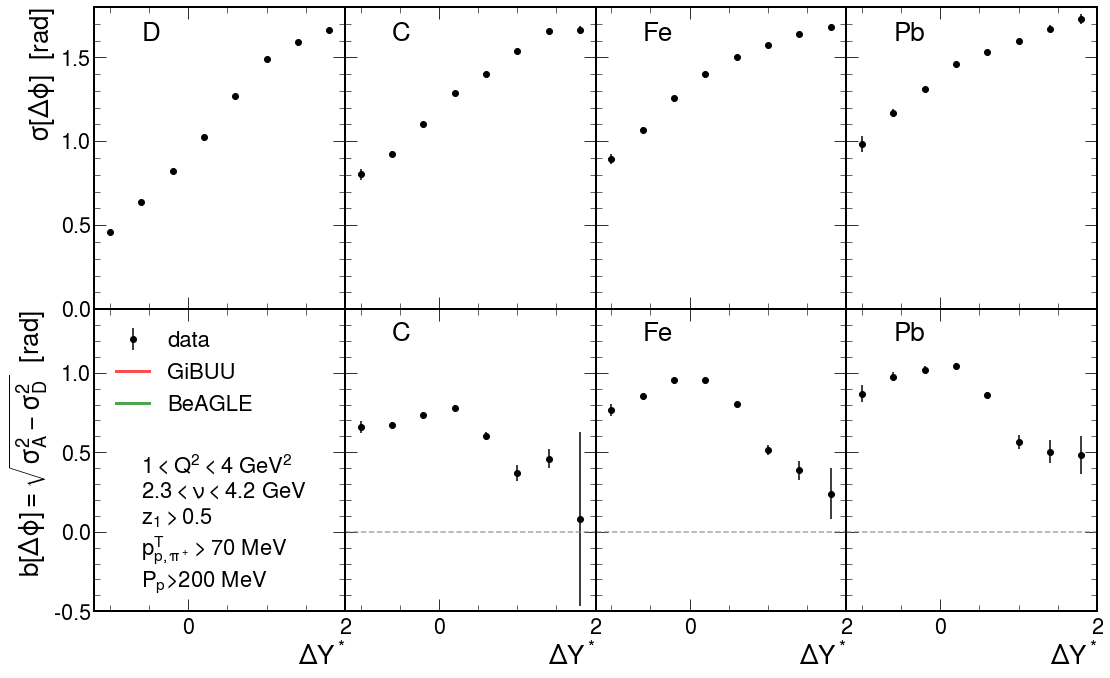

In [301]:

fig,axs=plt.subplots(2,4, figsize=(16,10), sharex='all', sharey='row')
colors={"GiBUU":"r", "BeAGLE":"g"}
#colors='tab:red tab:blue tab:orange tab:green'.split()
for res_set in "data",:
    
    sigmas_dPhi={}
    dsigmas_dPhi={}
    for i, A in enumerate("D C Fe Pb".split()):
        expr = f'{np.pi}-dphi'
        #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
        
        sigmas_dPhi[A]=[]
        dsigmas_dPhi[A]=[]
        x=np.array([-1.0+.4*k for k in range(8)])
        for j in range(len(x)):
            
            sigma=np.sqrt(sum(results[res_set]['dY_extended'][j][A].eval(f"C*(phi-{np.pi})**2"))/\
                         sum(results[res_set]['dY_extended'][j][A].C))
            sigmas_dPhi[A].append(sigma)
            C=results[res_set]['dY_extended'][j][A].C
            dCstat=results[res_set]['dY_extended'][j][A].dCstat
            #print("dCstat",dCstat)
            bin_centers=results[res_set]['dY_extended'][j][A].phi
            #print('bin_centers', bin_centers)
            dsigmas_dPhi[A].append(np.sqrt(sum(dCstat**2*(((bin_centers-np.pi)**2-sigma**2)/sum(C))**2))/(2*sigma))
                                   
        sigmas_dPhi[A]=np.array(sigmas_dPhi[A])
        #print('dsigmas',dsigmas_dPhi[A])
            #a=dfs_pair[A].query(q + f' and drap-ycm>{Dybins[j]} and drap-ycm<{Dybins[j+1]}').eval(expr)
            #x.append((Dybins[j]+Dybins[j+1])/2)
            #y.append(np.sqrt(np.mean(a**2)))
            #dy.append(np.std(a**2)/np.sqrt(len(a))/(2*y[-1]))
        plt.sca(axs[0][i])
        plt.ylim(0.0, 1.8)
        if res_set=='data':
            plt.text(-.6, 1.6, A)
        if res_set=='data':
            print(len(x))
            plt.errorbar(x,sigmas_dPhi[A],dsigmas_dPhi[A], color='k', ls='', marker='o')
        else:
            plt.fill_between(x,sigmas_dPhi[A]-dsigmas_dPhi[A],sigmas_dPhi[A]+dsigmas_dPhi[A], color=colors[res_set], alpha=0.7)
        if i ==0:
            y_D=np.array(y)
            dy_d=np.array(dy)
        else:
            plt.sca(axs[1][i])
            if res_set=='data':
                plt.text(-.6, 1.2, A)
            
            
            b=sigmas_dPhi[A]**2-sigmas_dPhi['D']**2
            b=b/np.sqrt(np.abs(b))
            db=np.hypot(dsigmas_dPhi[A]*sigmas_dPhi[A],dsigmas_dPhi['D']*sigmas_dPhi['D'])/b
            if res_set=='data':
                plt.errorbar(x,b,db, color='k', ls='', marker='o')
            else:
                plt.fill_between(x,b-db, b+db, color=colors[res_set], alpha=0.7)
            plt.ylim(-.5, 1.4)
            plt.xlim(-1.2, 2.0)
for i in range(4):
    axs[1][i].set_xlabel("$\\Delta Y^*$")

for i in range(1,4):
    axs[1][i].axhline(0, ls='--', alpha=0.7, color='0.5')
    
axs[0][0].set_ylabel("$\\sigma[\\Delta\\phi]$  [rad]")
axs[1][0].set_ylabel("$b[\\Delta\\phi]=\\sqrt{\\sigma_A^2-\\sigma^2_D}$  [rad]")

#now make the legend in the lower left corner
axs[1][0].errorbar([],[],[], color='k', ls='', marker='o', label='data')
for res_set in "GiBUU", "BeAGLE":
    axs[1][0].errorbar([],[], color=colors[res_set], label=res_set, ls='-', lw='3', alpha=0.7)
axs[1][0].legend(fontsize=22, loc='upper left')
cuts_txt="$1<Q^2<4$ GeV$^2$\n"+\
                      "$2.3<\\nu<4.2$ GeV\n"+\
                      "$z_1>0.5$\n"+\
                      "$p_{p,\pi^+}^T>70$ MeV\n"+\
                      "$P_p$>200 MeV"
axs[1][0].text(-0.6,-0.35, cuts_txt, fontsize=22)
#axs[1][0].axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("images/pi_p_widths_broadenings_extended.pdf")
plt.show()

In [36]:
pT1min=0.07
pT2min=0.07
pMin=0.2

q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
colors='tab:red tab:blue tab:orange tab:green k'.split()
for i, A in enumerate("D C Fe Pb".split()):
    expr = f'{np.pi}-dphi'
    #expr = 'drap-0.5*log((nu+sqrt(Q2+nu*nu))/(nu-sqrt(Q2+nu*nu)))'
    a=dfs_pair[A].query(q).eval(expr)
    print(np.sqrt(np.mean(a**2)))

1.1667781107735742
1.3561343869587799
1.4473420780495128
1.4858056657527354


In [ ]:
#data, GiBUU, sliceinfo = get_values("drap", "\Delta Y", np.linspace(0,3, 6),GiBUU_suffix=None)
data, _, sliceinfo = get_values("drap", "\Delta Y", np.linspace(0.2,2.2, 6),GiBUU_suffix=None, pMin=0.75)
data_corr = [d for d in data]
#data_corr = [apply_endcap_corrections(d) for d in data]
#add_syst_error_from_misid(data_corr, 'dY')
#add_syst_error_from_cuts(data_corr, 'dY')
#add_syst_error_from_coulomb(data_corr, 'dY')
data_corr=add_syst_from_mixing(data_corr, "dY")
#add_syst_from_fbw(data_corr)
#ghost_bins_correction(data_corr, 'dY', [1])


print("this should be one", sum([sum(data[i]['D'].C)*2*np.pi/8*.5 for i in range(5)]))
print("this should be one", sum([sum(pred_BeAGLE['dY'][i]['D'].C)*2*np.pi/8*.5 for i in range(5)]))

all_data_uncorr['dY']=data
all_data['dY']=data_corr
all_GiBUU['dY']=GiBUU
all_sliceinfo['dY'] = sliceinfo

#print(data_corr[0]['D'].dCsyst/data_corr[0]['D'].C)
arg=dict(ymax=(2.3, 40), legend_panel=0)
make_plots_new(normalize(data_corr), normalize(pred_BeAGLE['dY']), sliceinfo, filename_tag='dY', **arg)

In [66]:
print(np.max(np.abs(devs['width'][:])))
print(np.max(np.abs(devs['broad'][:])))

0.2730137657190592
0.3798927708634461


Text(0, 1, 'events')

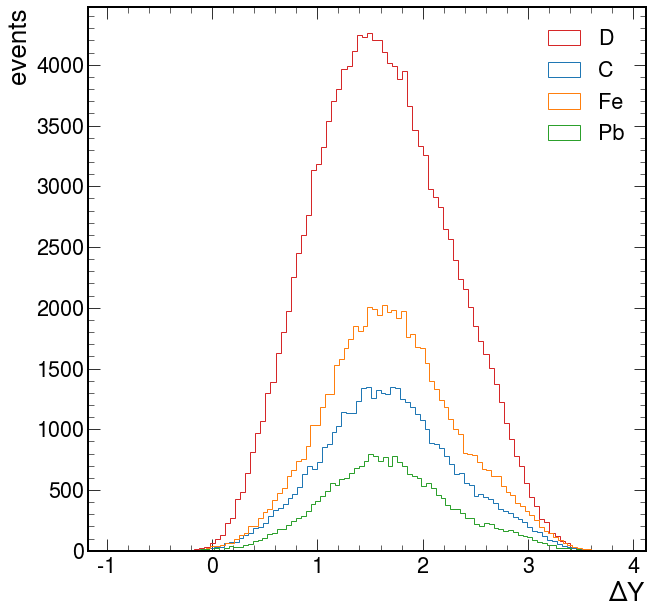

In [84]:

for A,col in zip("D C Fe Pb".split(),"tab:red tab:blue tab:orange tab:green".split()):
    plt.hist(dfs_pair[A].drap, histtype='step', bins=100, color=col, label=A)
plt.legend()
plt.xlabel("$\Delta Y$")
plt.ylabel("events")

In [218]:
coeffs_high_range1=120.251,-1168.19,5237.42,-13638.1,22325.3,-23649.6,16177.8,-6894.16,1663.4,-173.474
coeffs_low_range1=-26.8257,153.155,-408.979,673.476,-790.433,708.255,-474.843,217.295,-58.6269,6.90981
coeffs_high_range2=1.59223,-1.49056,0.676338,-0.104644
coeffs_low_range2=-1.1009,0.719988,-0.280016,0.0319352

print("&".join([f"p{i}" for i in range(5)]) +"\\\\")
print("&".join([f"{a}" for a in coeffs_high_range1[0:5]])+"\\\\")
print("&".join([f"{a}" for a in  coeffs_low_range1[0:5]])+"\\\\")
print("&".join([f"{a}" for a in  coeffs_high_range2[0:4]])+"&0\\\\")
print("&".join([f"{a}" for a in  coeffs_low_range2[0:4]])+"&0\\\\")
print("&".join([f"p{i}" for i in range(5)]) +"\\\\")
print("&".join([f"{a}" for a in coeffs_high_range1[5:10]])+"\\\\")
print("&".join([f"{a}" for a in  coeffs_low_range1[5:10]])+"\\\\")
print("&".join([f"{0}" for a in coeffs_high_range1[0:5]])+"\\\\")
print("&".join([f"{0}" for a in  coeffs_low_range1[0:5]])+"\\\\")

p0&p1&p2&p3&p4\\
120.251&-1168.19&5237.42&-13638.1&22325.3\\
-26.8257&153.155&-408.979&673.476&-790.433\\
1.59223&-1.49056&0.676338&-0.104644&0\\
-1.1009&0.719988&-0.280016&0.0319352&0\\
p0&p1&p2&p3&p4\\
-23649.6&16177.8&-6894.16&1663.4&-173.474\\
708.255&-474.843&217.295&-58.6269&6.90981\\
0&0&0&0&0\\
0&0&0&0&0\\


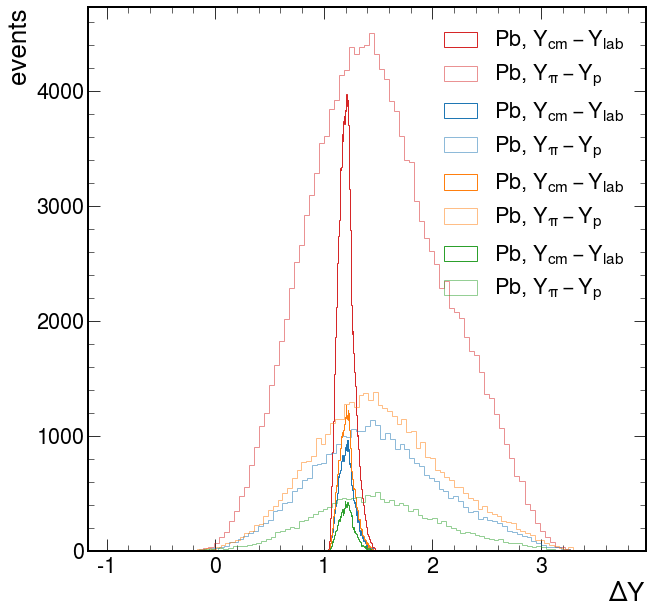

In [472]:
colors='tab:red tab:blue tab:orange tab:green k'.split()
for i, a in enumerate("D C Fe Pb".split()):
    plt.hist(dfs_pair[a]['ycm'], histtype='step', bins=100, color=colors[i], label=f'{A}, $Y_{{\\rm cm}}-Y_{{\\rm lab}}$')
    plt.hist(dfs_pair[a]['drap'], histtype='step', bins=100, color=colors[i], alpha=0.5, label=f"{A}, $Y_\pi-Y_p$")
plt.xlabel("$\Delta Y$")
plt.ylabel("events")
plt.legend()

In [468]:
E=5+.938
p=5
print(np.log(np.sqrt((E+p)/(E-p))))

1.2281241474502467


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.93917242, -0.89298881, -0.8468052 , -0.80062158, -0.75443797,
        -0.70825435, -0.66207074, -0.61588713, -0.56970351, -0.5235199 ,
        -0.47733628, -0.43115267, -0.38496905, -0.33878544, -0.29260183,
        -0.24641821, -0.2002346 , -0.15405098, -0.10786737, -0.06168376,
        -0.01550014,  0.03068347,  0.07686709,  0.1230507 ,  0.16923431,
         0.21541793,  0.26160154,  0.30778516,  0.35396877,  0.40015238,
         0.446336  ,  0.49251961,  0.53870323,  0.58488684,  0.63107046,
         0.67725407,  0.72343768,  0.7696213 ,  0.81580491,  0.86198853,
         0.90817214,  0.95435575,  1.00053937,  1.04672298,  1.0929066 ,
         1.13909021,  1.18527382,  1.23145744,  1.27764105,  1.32382467,
         1.37000828, 

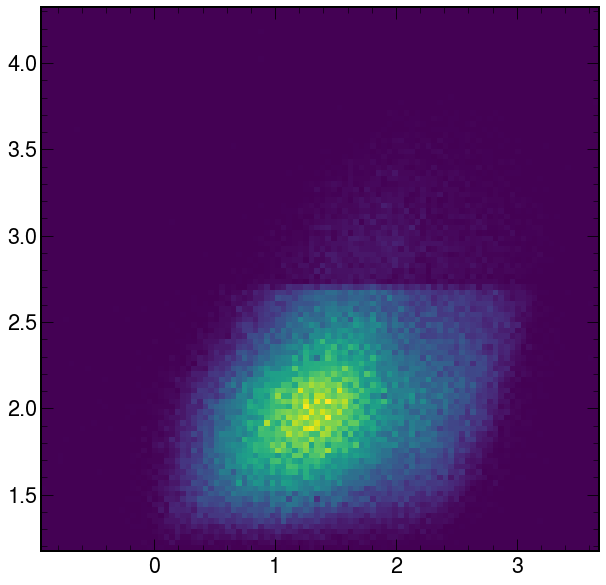

In [639]:
plt.hist2d(dfs_pair['D'].drap, dfs_pair['D'].h1_p,bins=100)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([1.18984095, 1.21716824, 1.24449553, 1.27182282, 1.29915011,
        1.3264774 , 1.35380468, 1.38113197, 1.40845926, 1.43578655,
        1.46311384, 1.49044113, 1.51776841, 1.5450957 , 1.57242299,
        1.59975028, 1.62707757, 1.65440486, 1.68173214, 1.70905943,
        1.73638672, 1.76371401, 1.7910413 , 1.81836859, 1.84569587,
        1.87302316, 1.90035045, 1.92767774, 1.95500503, 1.98233232,
        2.0096596 , 2.03698689, 2.06431418, 2.09164147, 2.11896876,
        2.14629605, 2.17362333, 2.20095062, 2.22827791, 2.2556052 ,
        2.28293249, 2.31025978, 2.33758706, 2.36491435, 2.39224164,
        2.41956893, 2.44689622, 2.47422351, 2.50155079, 2.52887808,
        2.55620537, 2.58353266, 2.61085995, 2.63818724, 2.66551452,
   

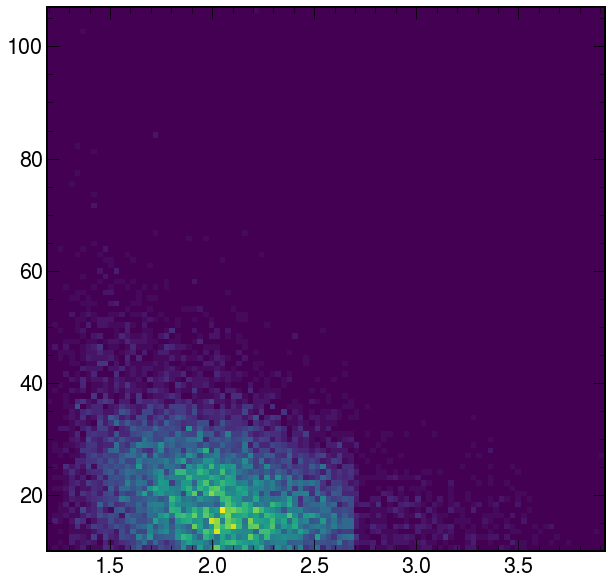

In [883]:
plt.hist2d(dfs_pair['Pb'].h1_p, dfs_pair['Pb'].h1_th, bins=100)

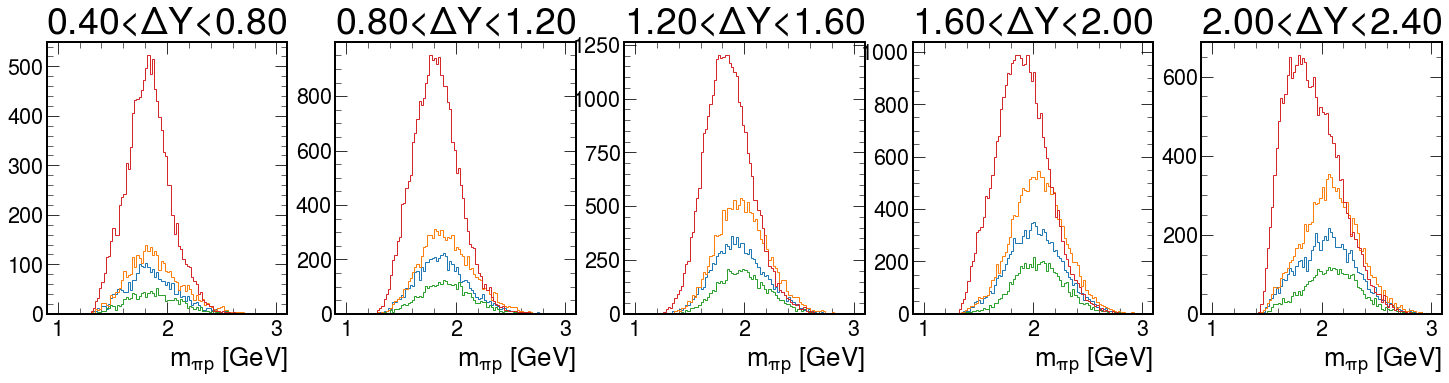

In [79]:
bins= np.linspace(0.4,2.4, 6)
fig, axs=plt.subplots(1,5, figsize=(25,5), sharex='all')
for i in range(len(bins)-1):
    pT1min=0.07
    pT2min=0.07
    pMin=0.2
    q = f"h1_pid==211   and h1_cm_pt > {pT1min} and "+\
                 f"h2_cm_pt > {pT2min} and h1_z>0.5 and h2_pid==2212 and h2_p>{pMin} and pass_proton_TOF_cut"
    q+= f" and drap>={bins[i]} and drap<{bins[i+1]}"
    for A in "C Fe Pb D".split():
        dfq=dfs_pair[A].query(q)
        #build a long string because the pair_mass variable isn't correct 
        #pair_mass="sqrt((sqrt(h1_p**2+0.1396**2) + sqrt(h2_p**2+0.9383**2))**2 - h1_p**2 - h2_p**2 - 2*h1_p*h2_p*cosTh12)"
        #pair_mass=pair_mass.replace("cosTh12", "(cos(h1_th)*cos(h2_th)+sin(h1_th)*sin(h2_th)*cos(h2_ph-h1_ph))")
        #for a in "h1_ph h2_ph h1_th h2_th".split():
        #    pair_mass=pair_mass.replace(a, f"{a}*{np.pi/180}")
                                    
        axs[i].hist(dfq.eval("pair_mass"), histtype='step',bins=100, range=(1,3))
    axs[i].set_xlabel("$m_{\pi p}$ [GeV]")
    axs[i].set_title(f"{bins[i]:.2f}<$\Delta Y$<{bins[i+1]:.2f}")

(array([ 153., 2061., 6204., 6617., 3885., 2496., 1538.,  799.,  309.,
          57.]),
 array([-0.3416152 , -0.15156021,  0.03849479,  0.22854978,  0.41860478,
         0.60865977,  0.79871477,  0.98876976,  1.17882476,  1.36887975,
         1.55893475]),
 <BarContainer object of 10 artists>)

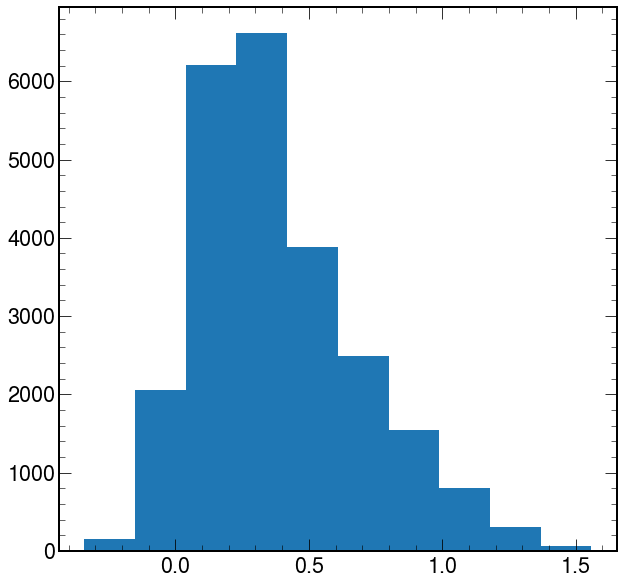

In [15]:
plt.hist(dfs_pair['Pb'].eval("h2_rap+ycm"))

In [573]:
for a in "D C Fe Pb".split():
    print(a, np.mean(dfs_pair[a].query("h1_pid==211   and h1_cm_pt > .07 and "+\
                 f"h1_z>0.5 and h2_pid==2212 and h2_p>0.2 and pass_proton_TOF_cut ").h2_p))

D 0.8890446005201077
C 0.7071535859852505
Fe 0.6320879448012687
Pb 0.6132681510194411
